# Environment для крестиков-ноликов

In [1]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count

import cProfile
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
# rc('font',**{'family':'sans-serif'})
# rc('text', usetex=True)
# rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
# rc('text.latex',preamble=r'\usepackage[russian]{babel}')
# rc('figure', **{'dpi': 300})

/home/egorov/anaconda3/envs/made_adl/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
import collections
from collections import defaultdict
from tqdm.notebook import tqdm

In [3]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [4]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
#             else:
#                 ax.text( a[1] , a[0] , "???", fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
    cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, actions)

In [5]:
def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print(f"Крестики выиграли! reward={reward} done={done}")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print(f"Нолики выиграли! reward={reward} done={done}")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

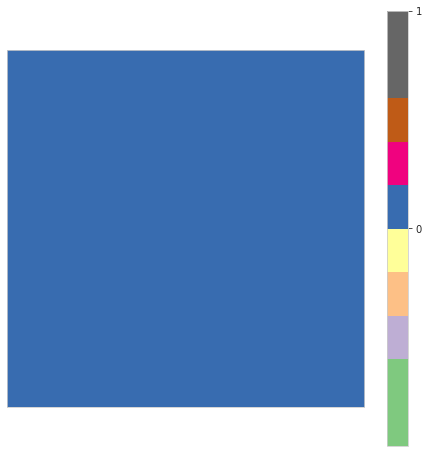

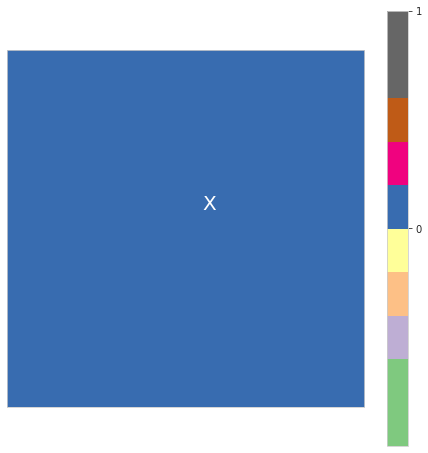

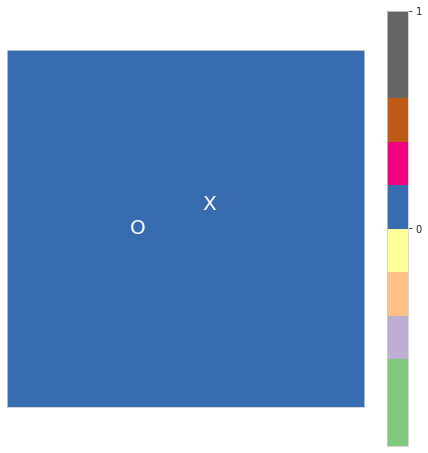

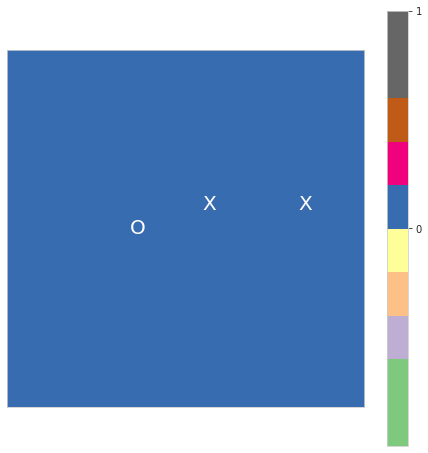

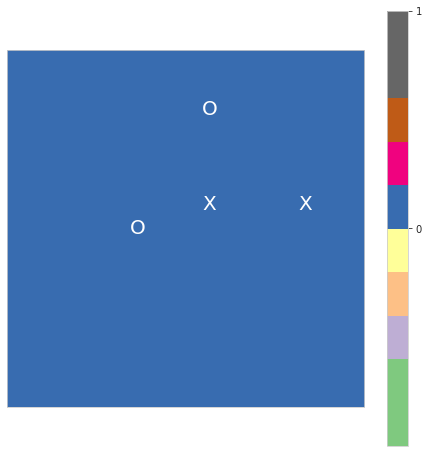

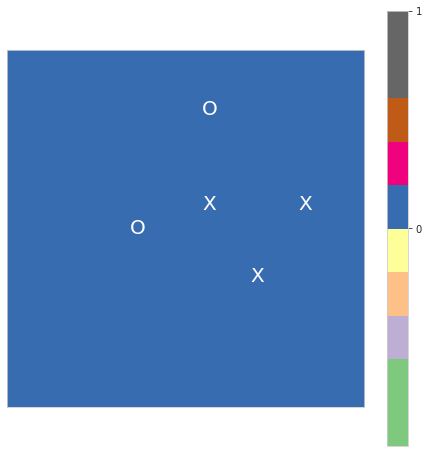

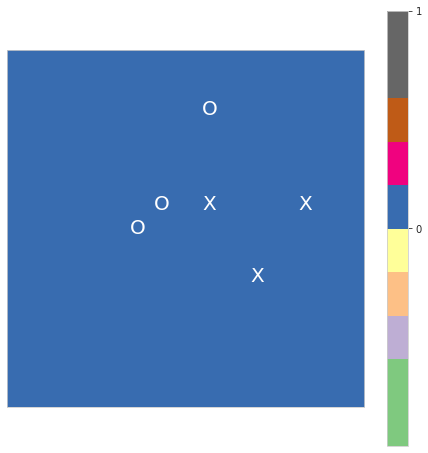

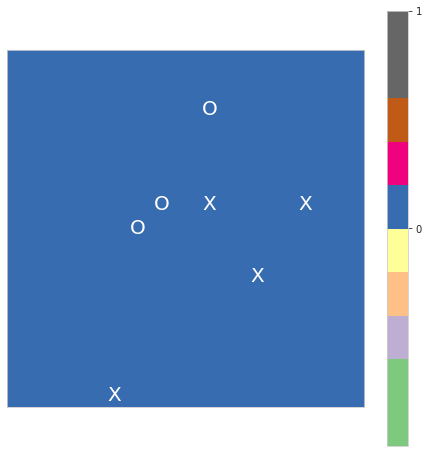

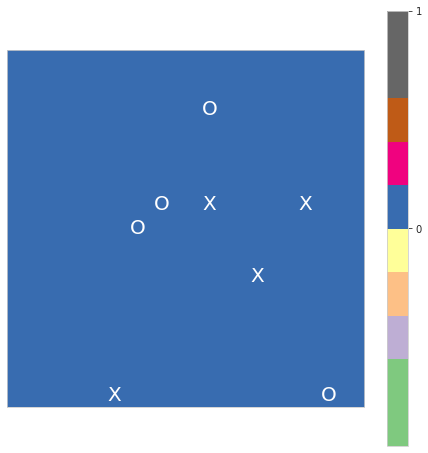

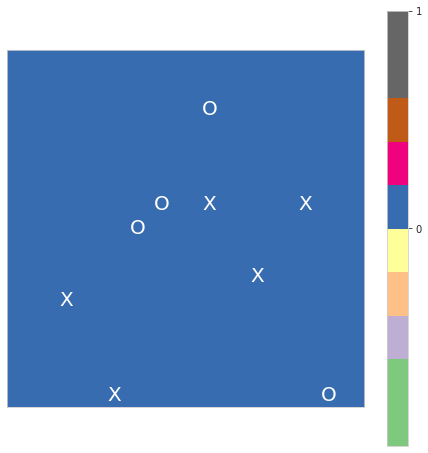

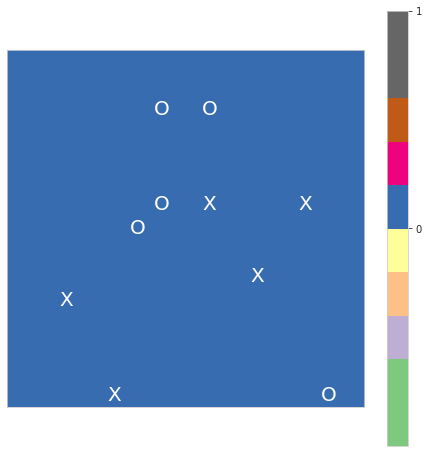

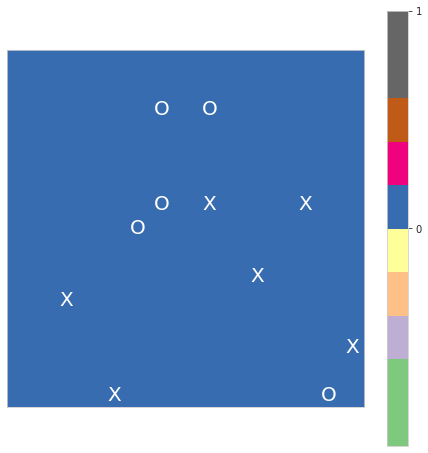

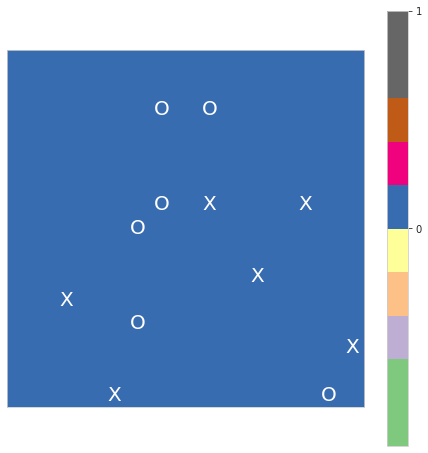

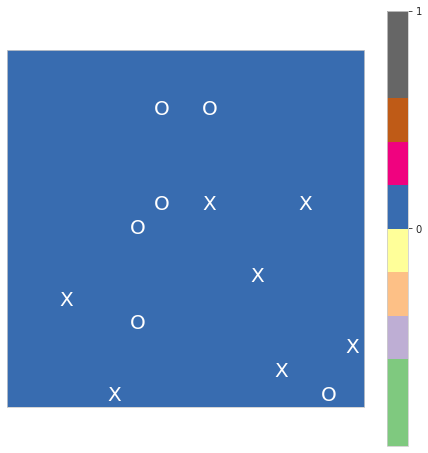

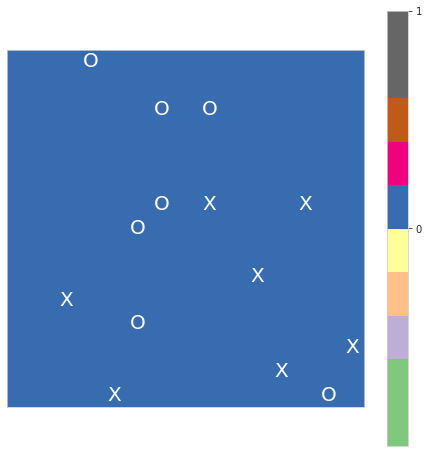

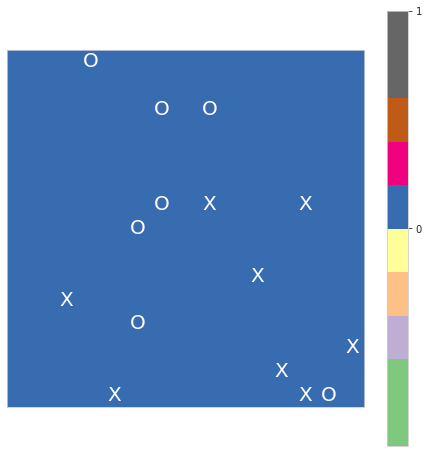

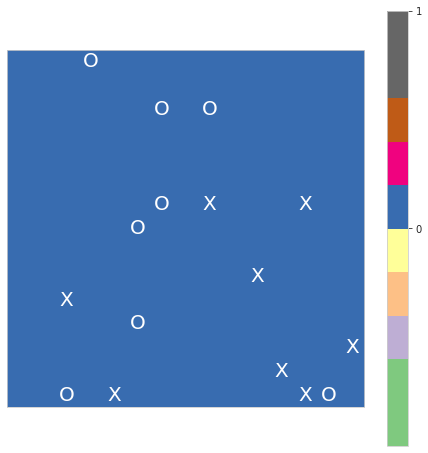

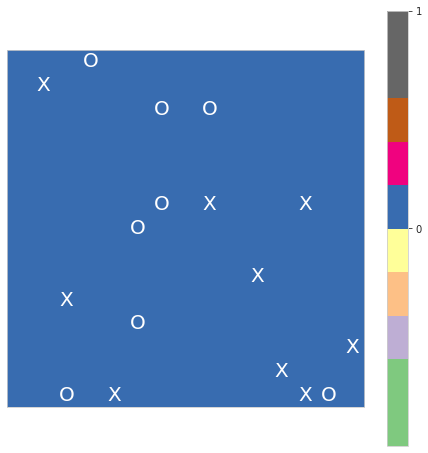

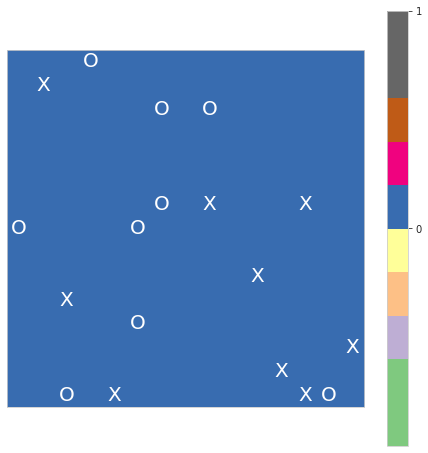

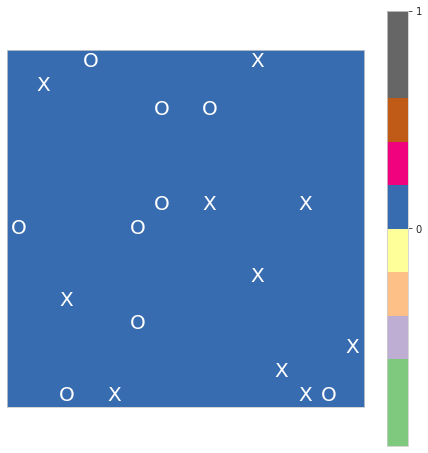

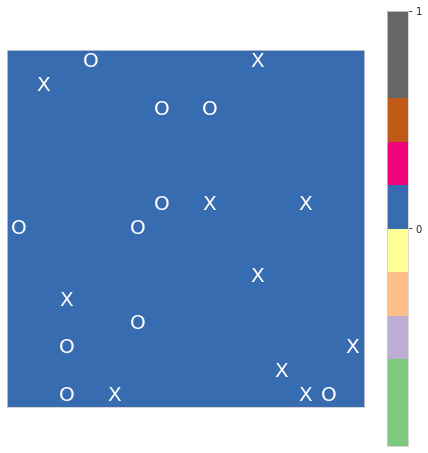

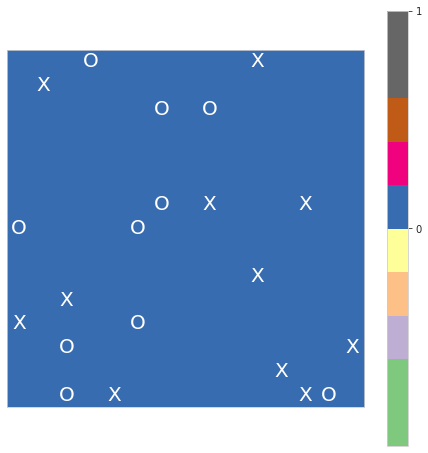

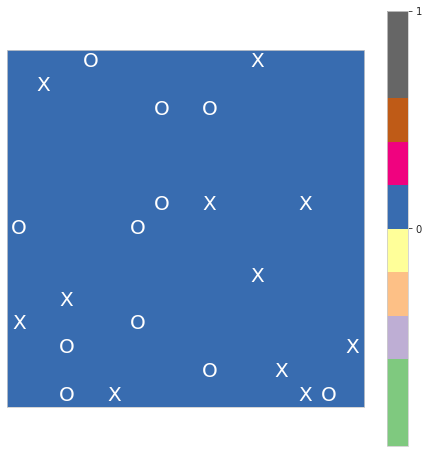

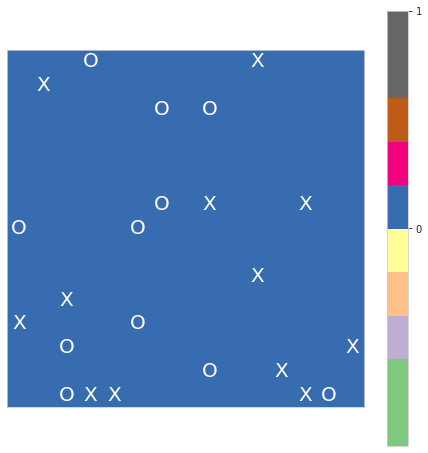

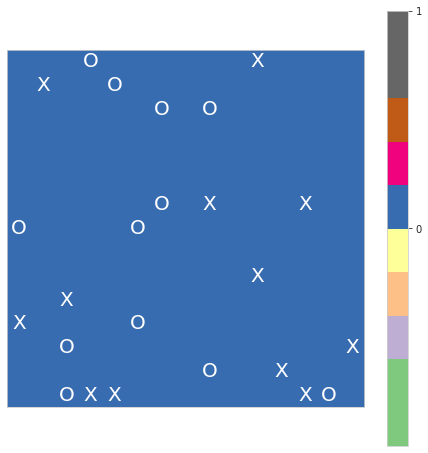

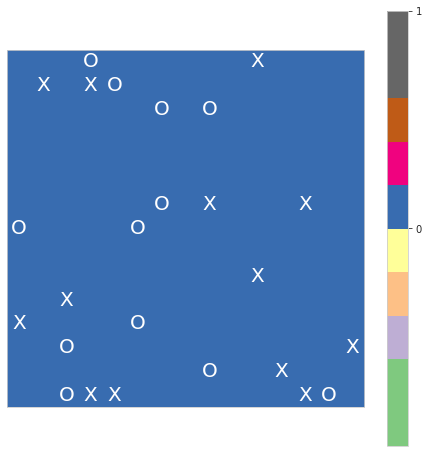

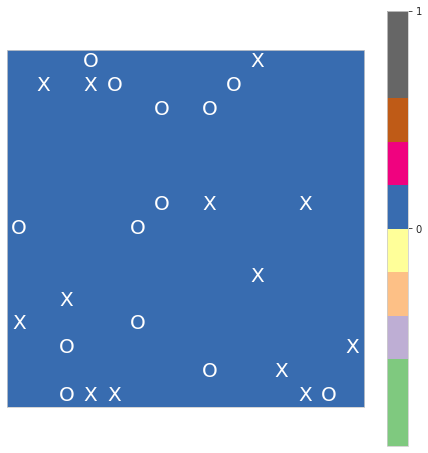

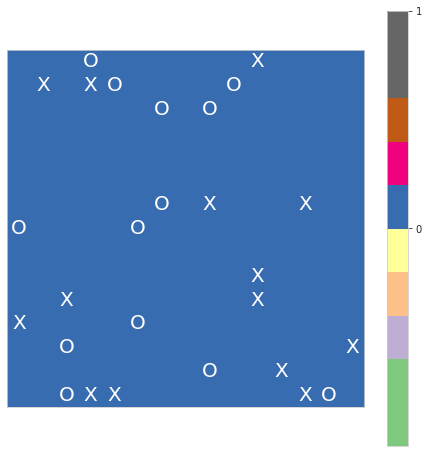

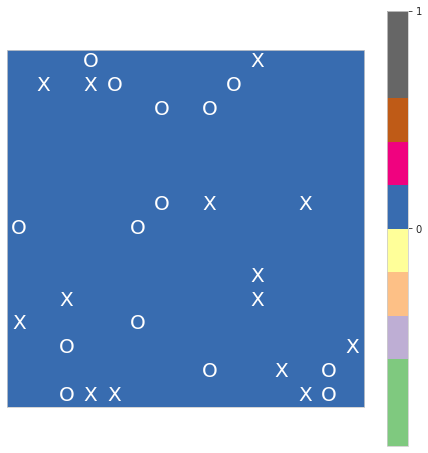

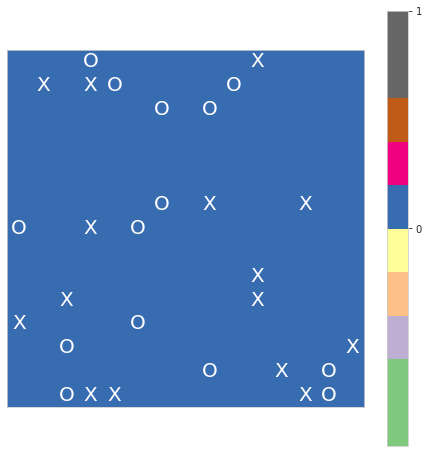

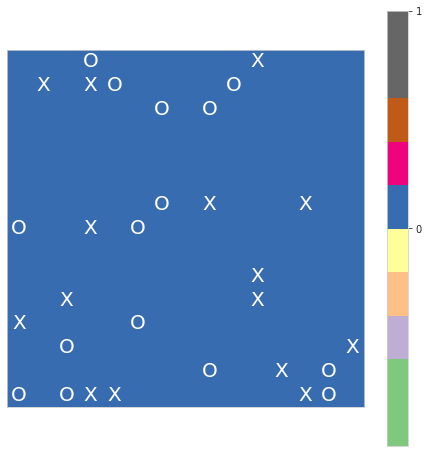

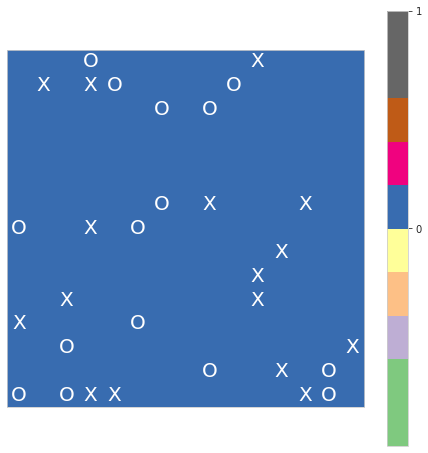

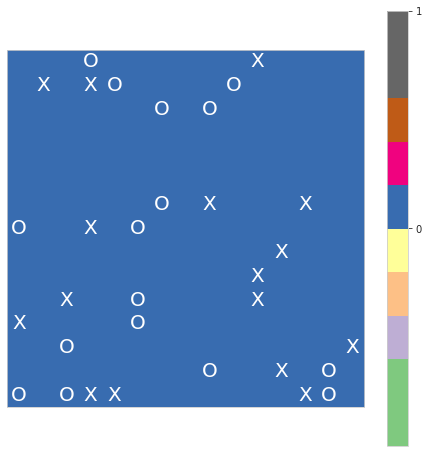

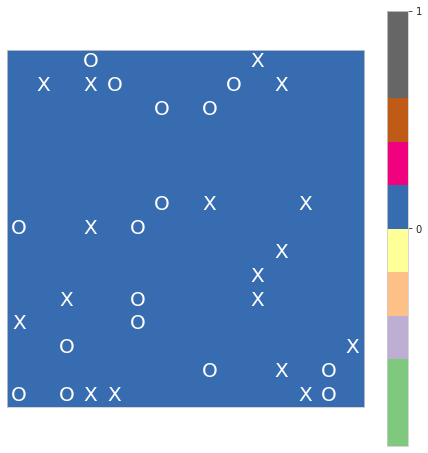

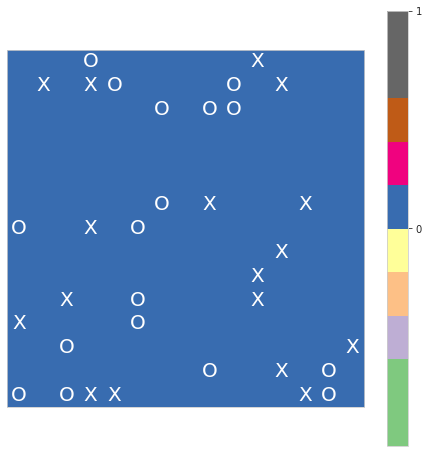

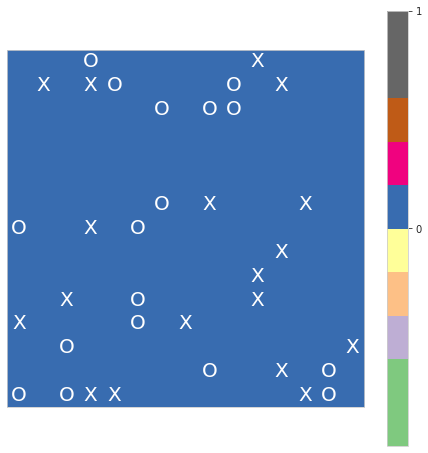

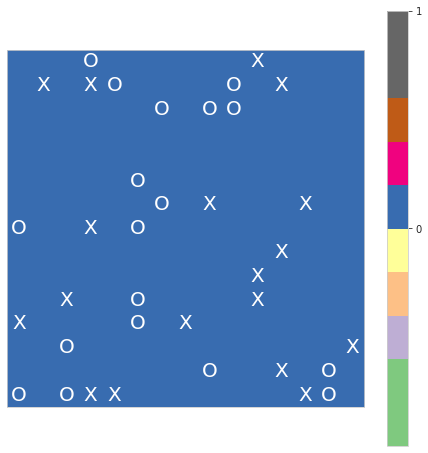

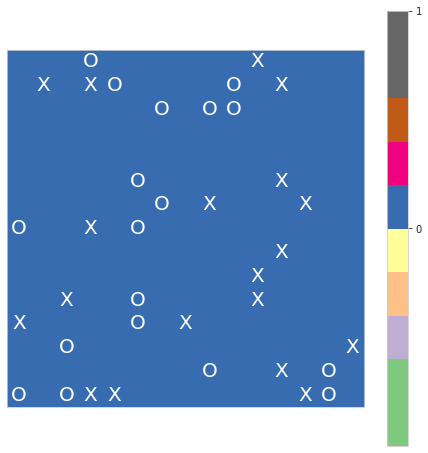

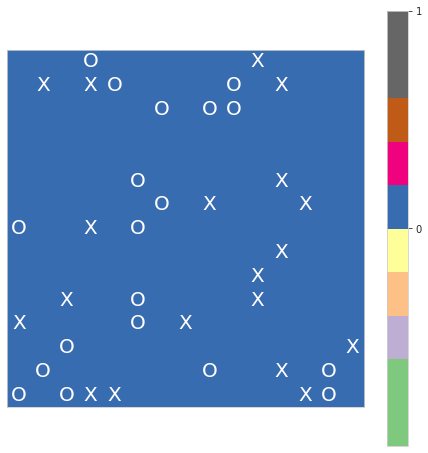

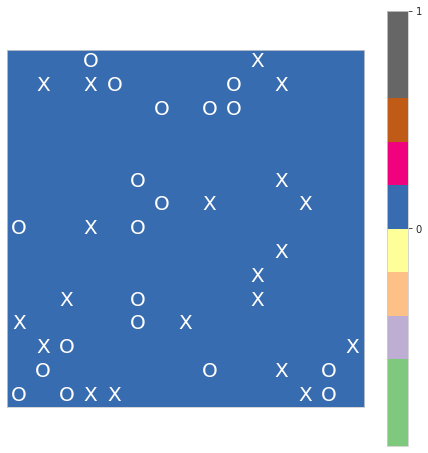

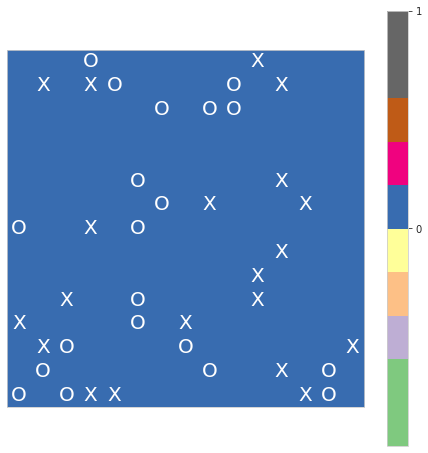

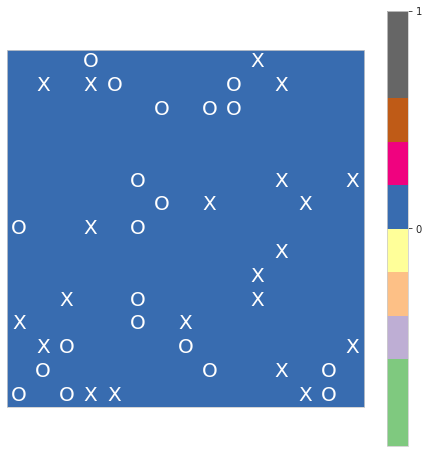

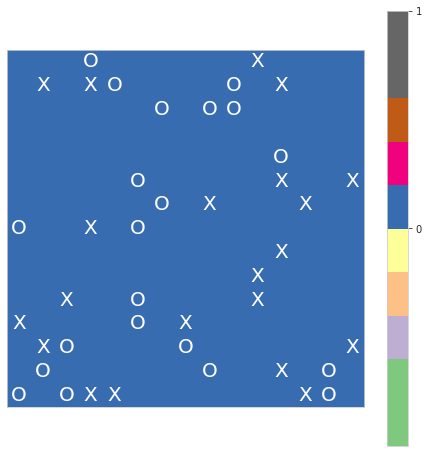

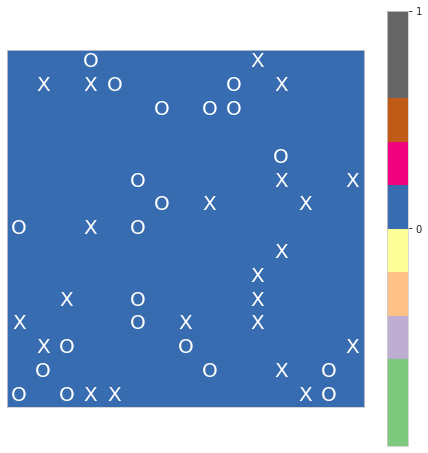

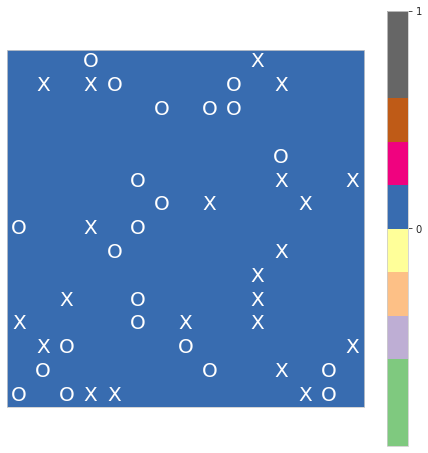

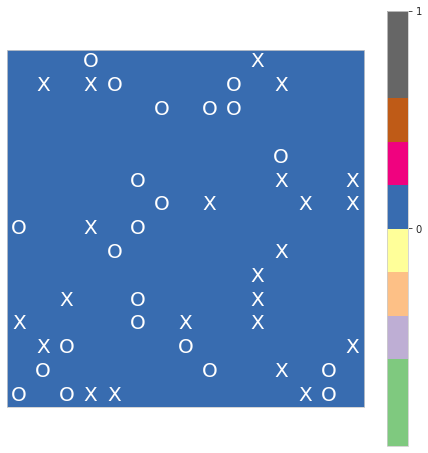

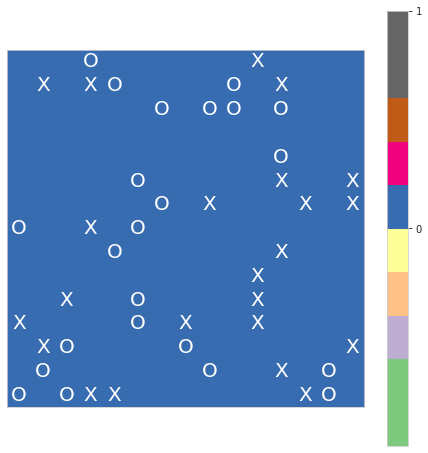

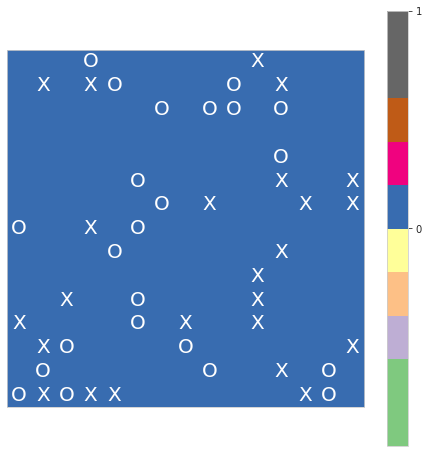

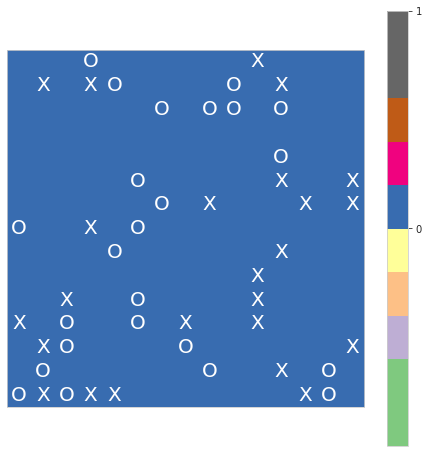

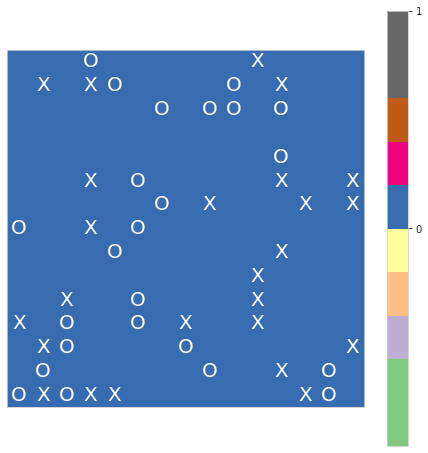

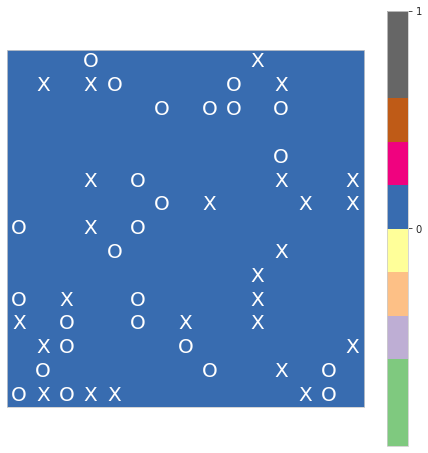

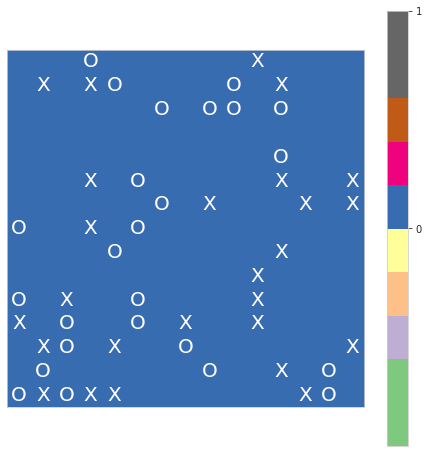

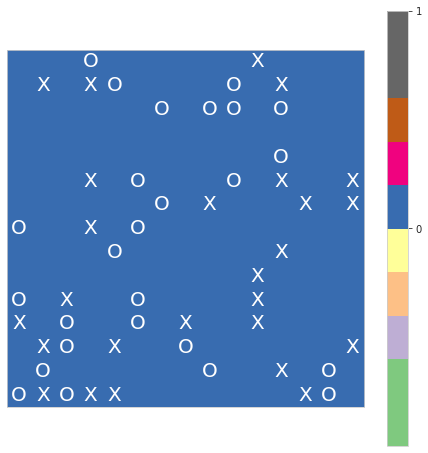

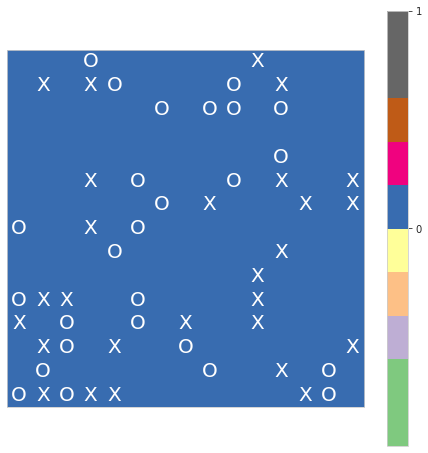

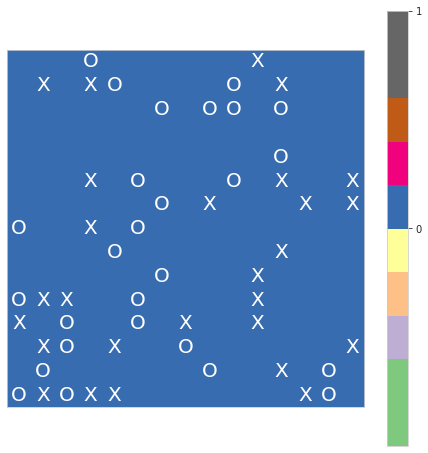

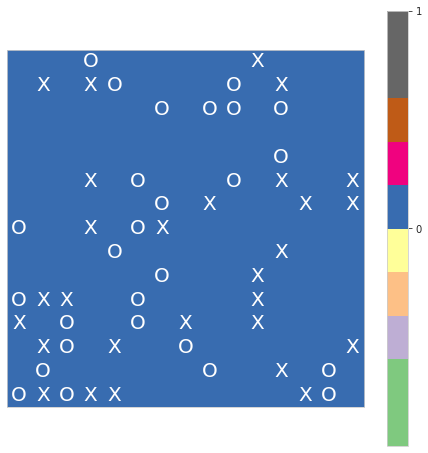

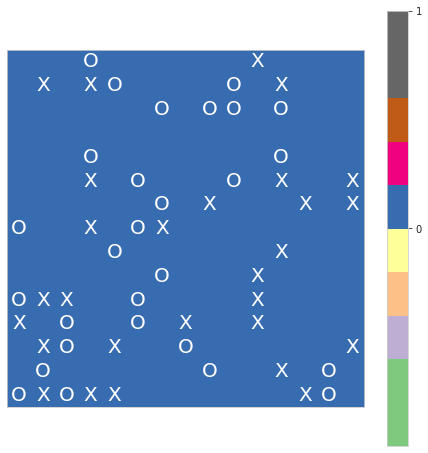

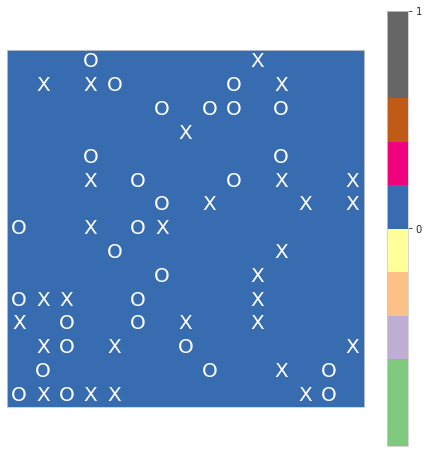

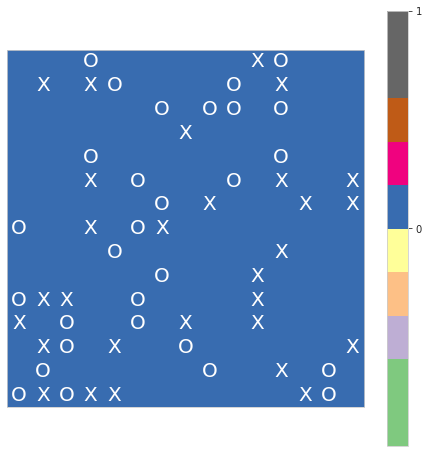

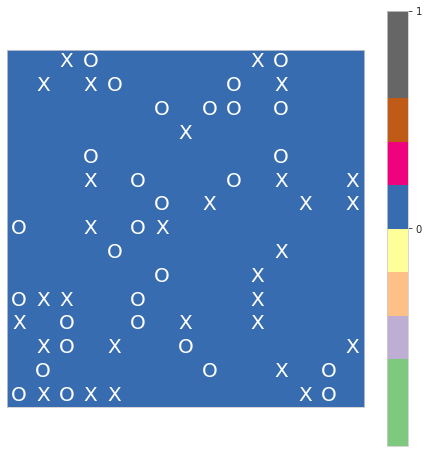

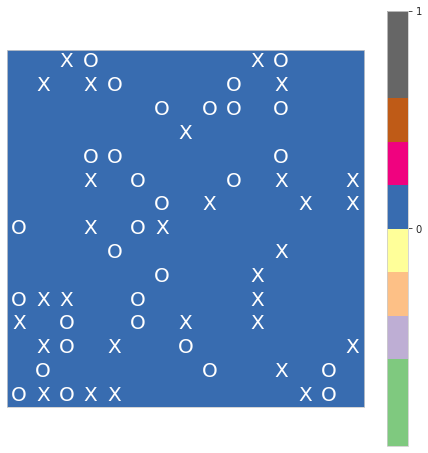

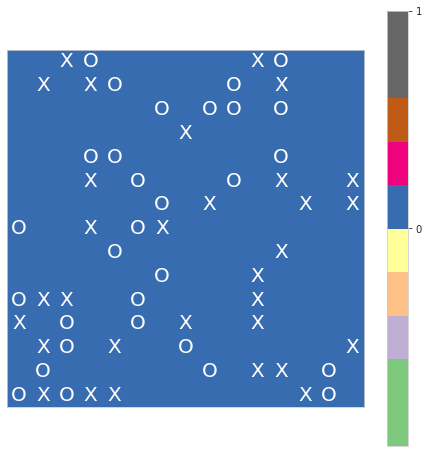

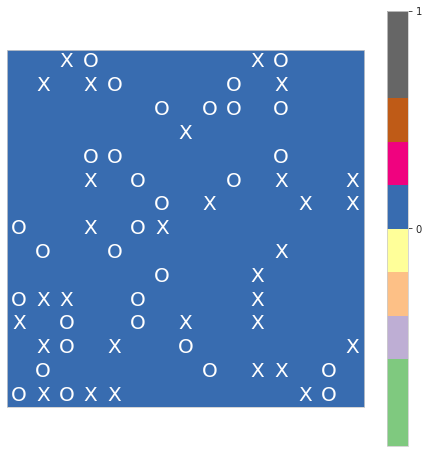

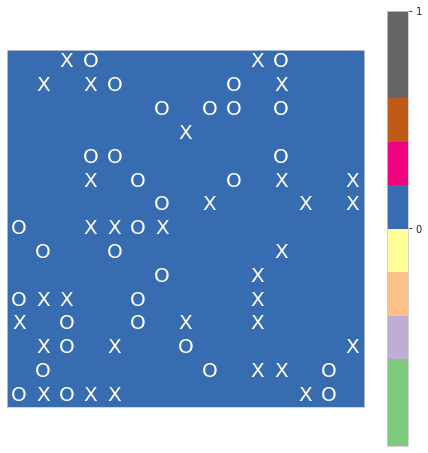

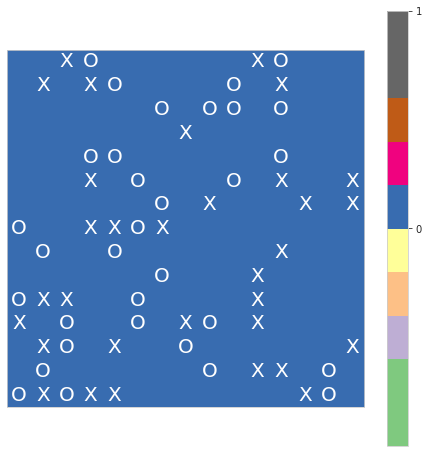

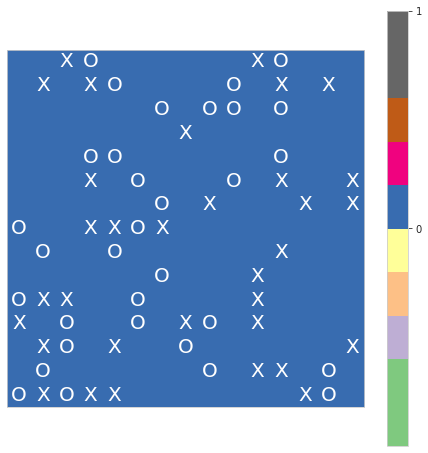

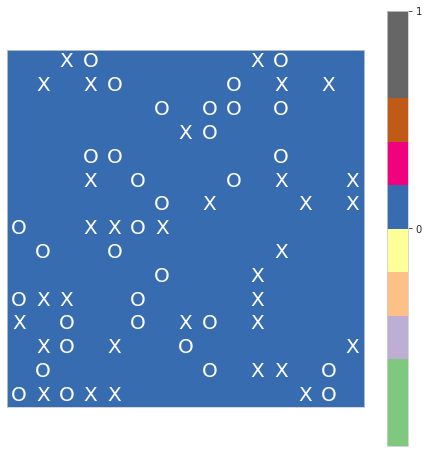

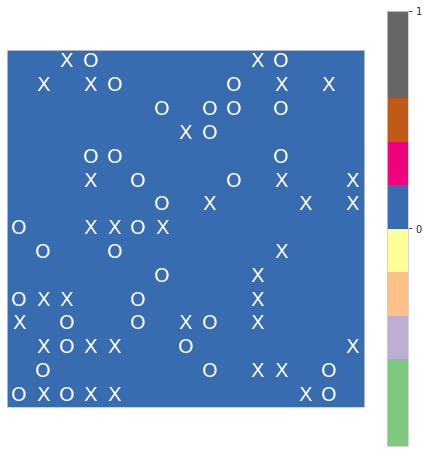

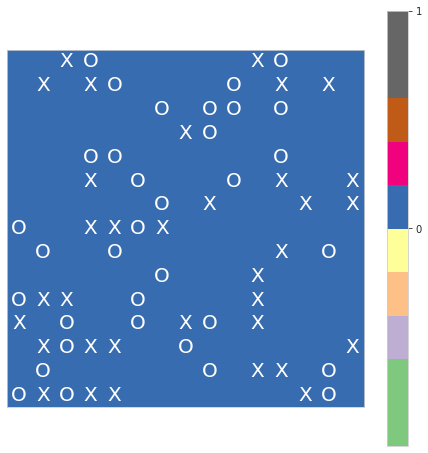

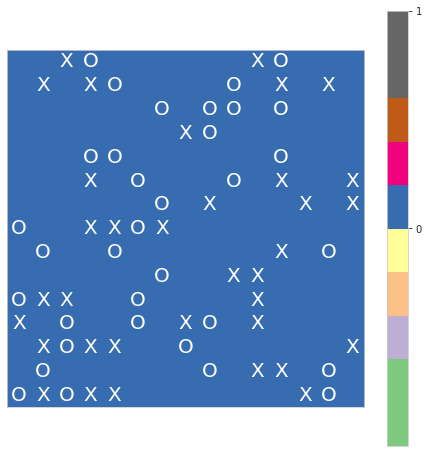

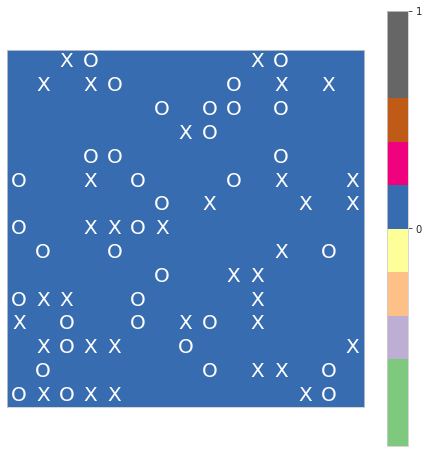

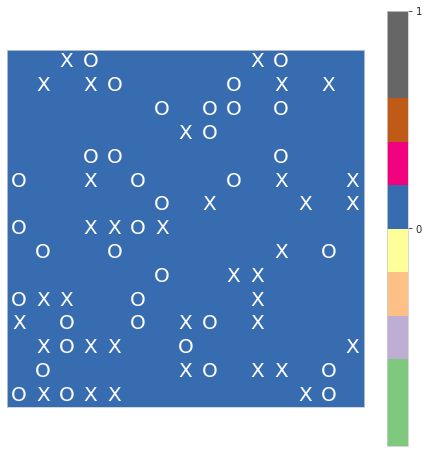

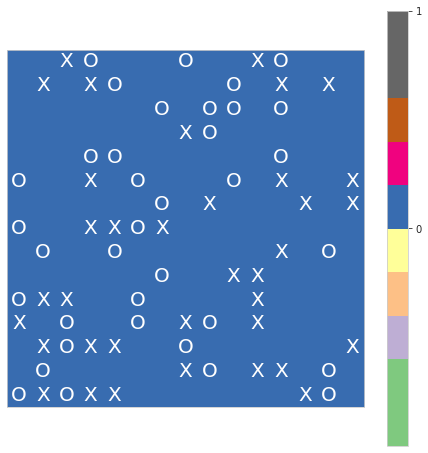

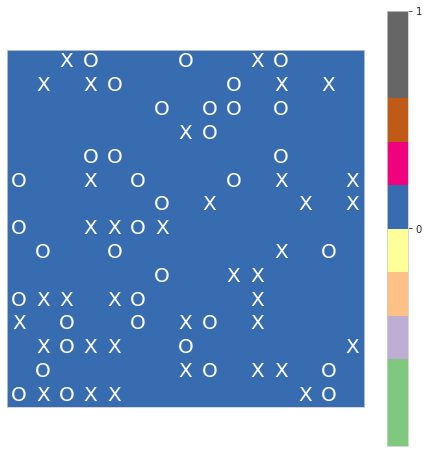

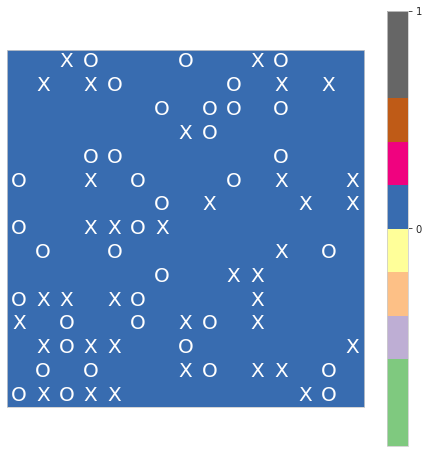

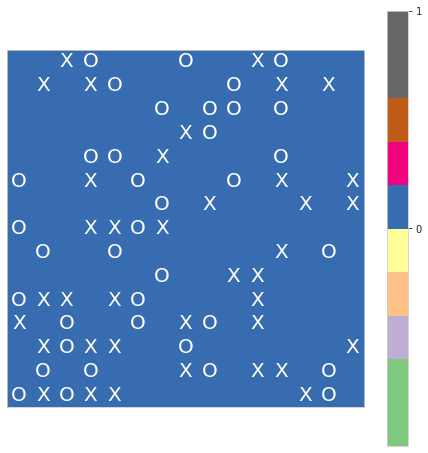

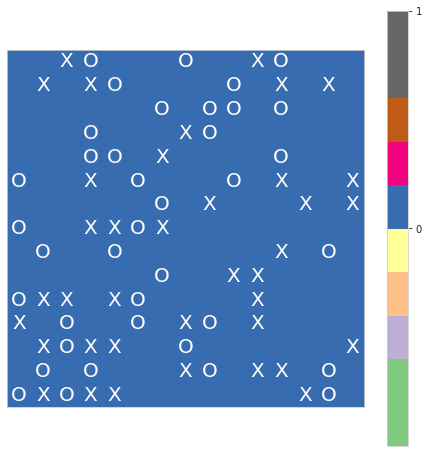

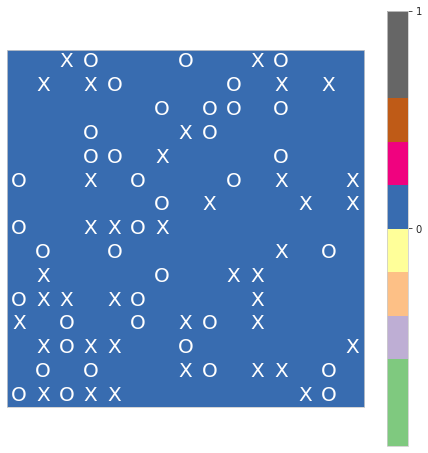

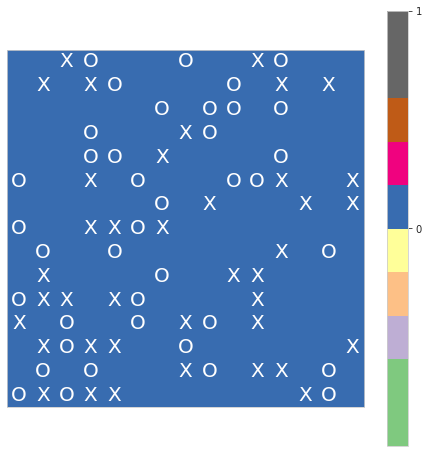

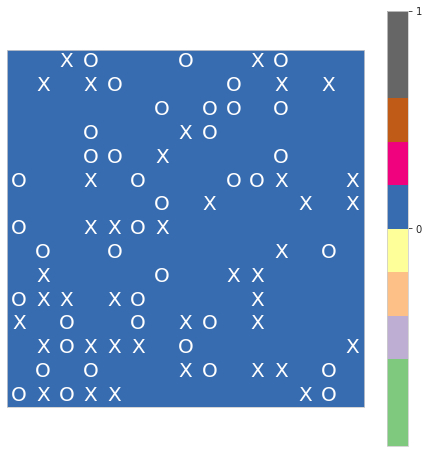

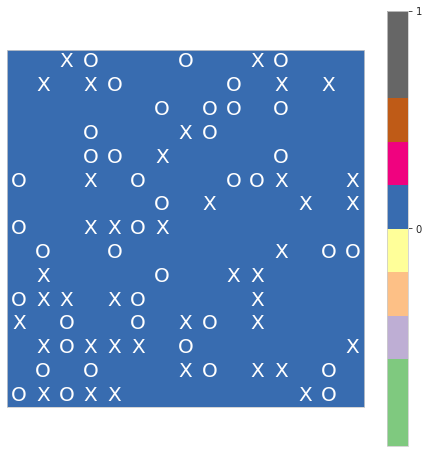

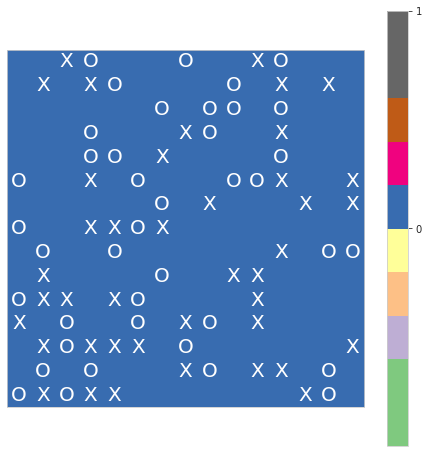

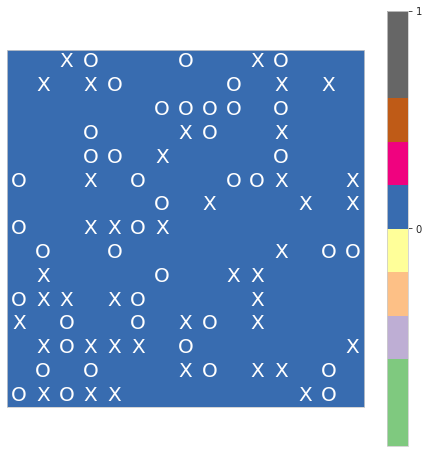

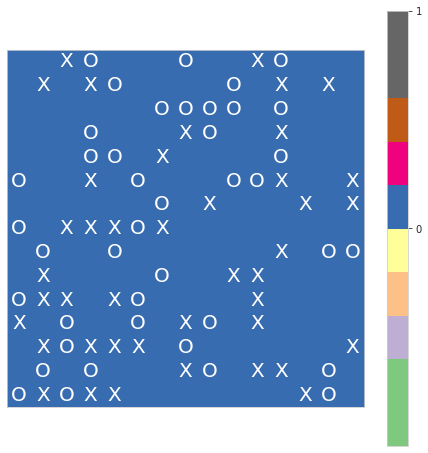

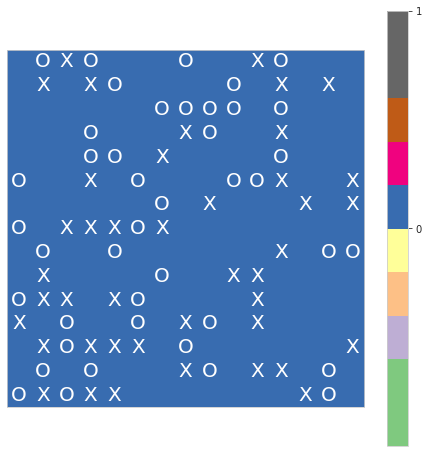

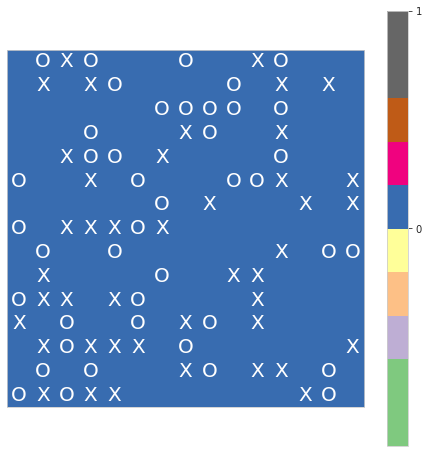

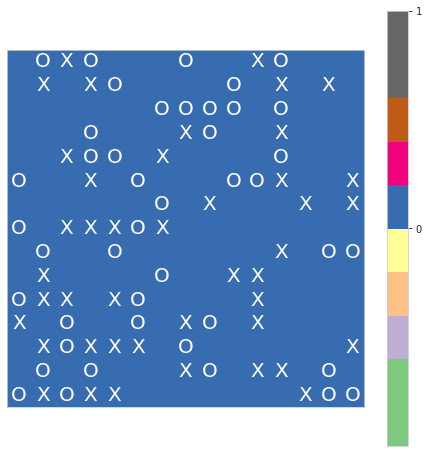

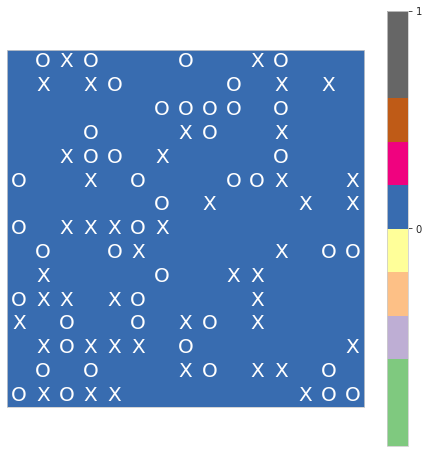

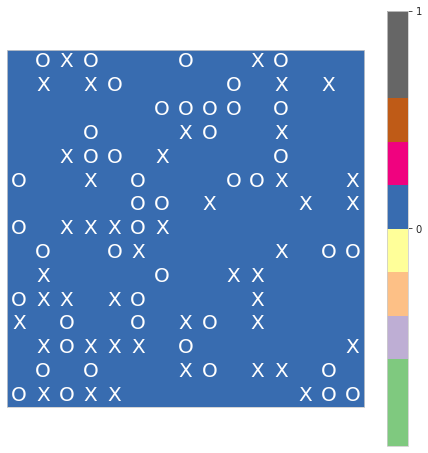

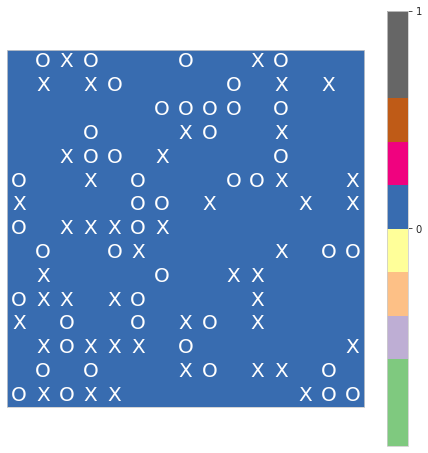

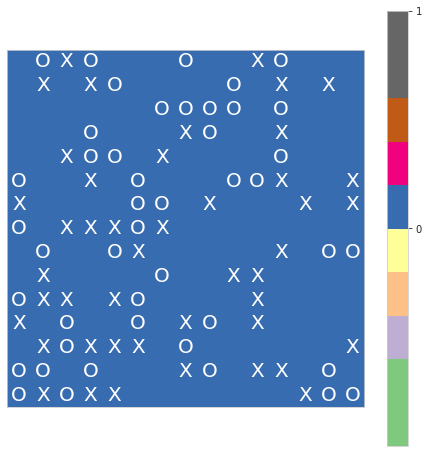

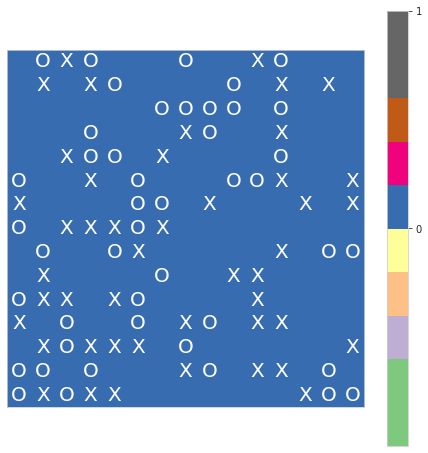

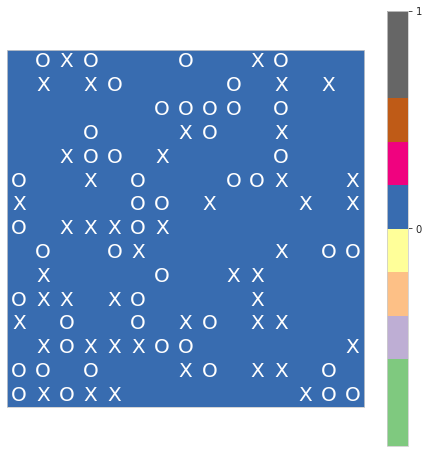

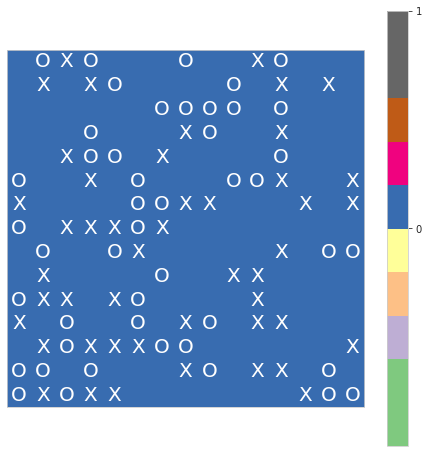

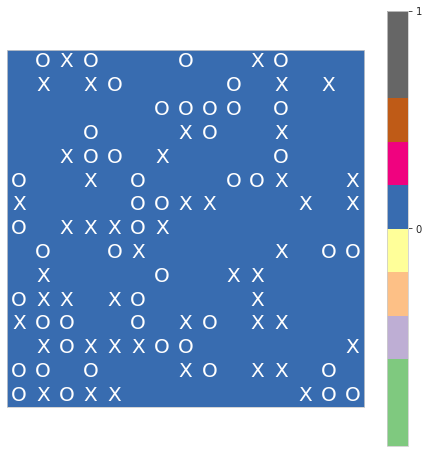

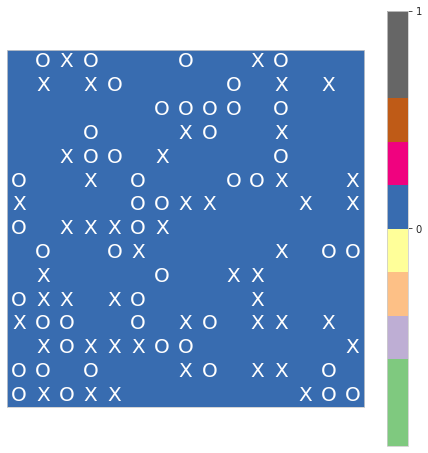

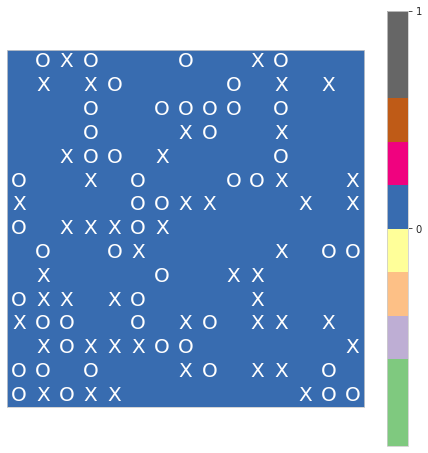

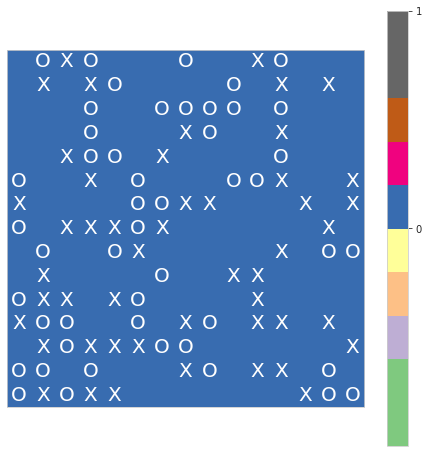

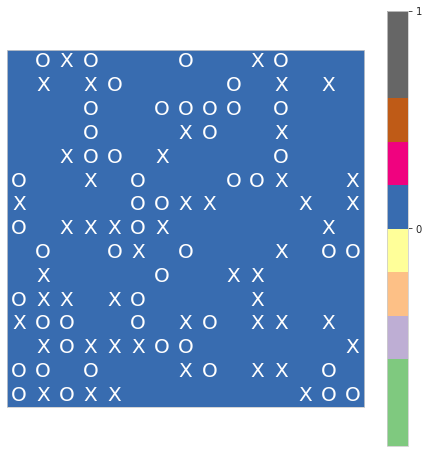

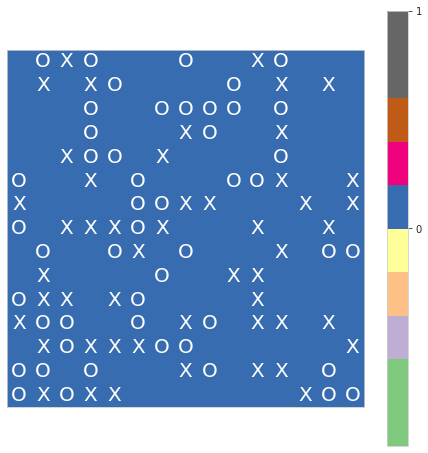

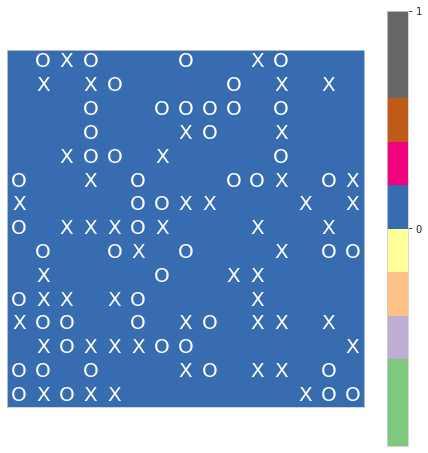

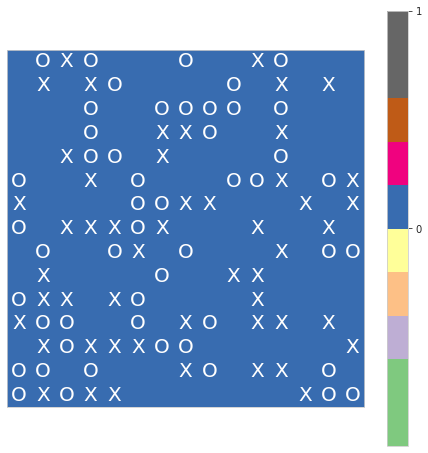

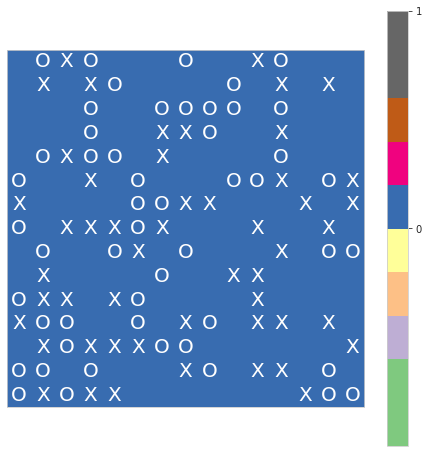

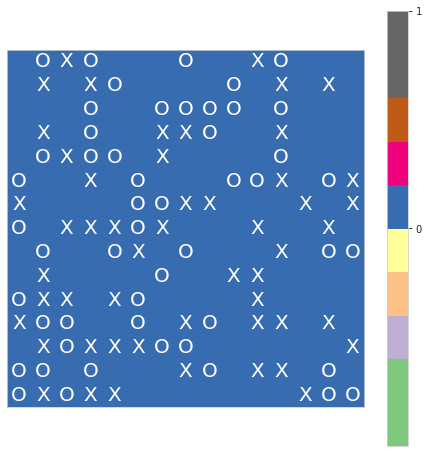

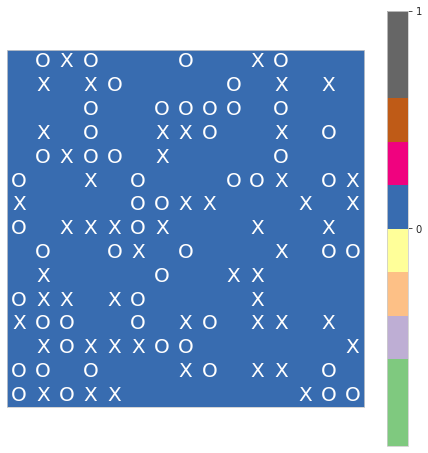

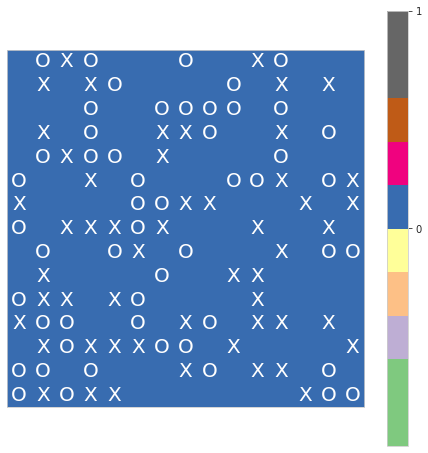

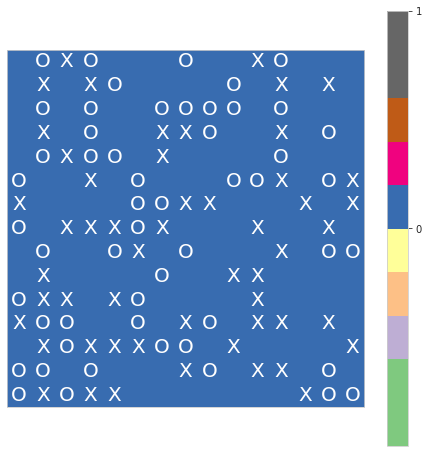

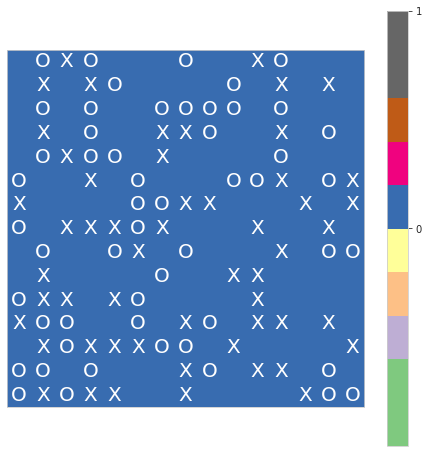

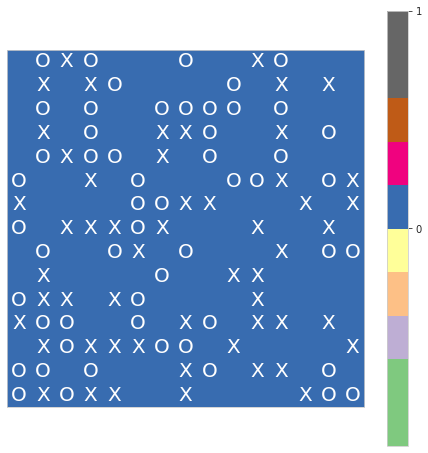

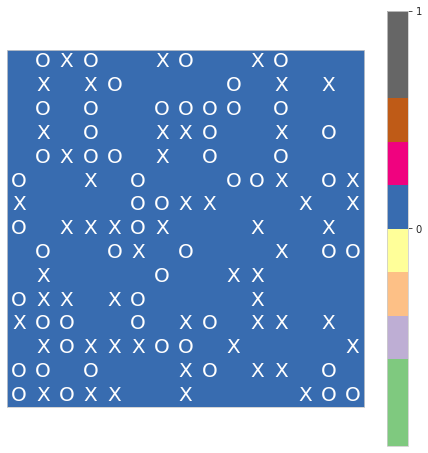

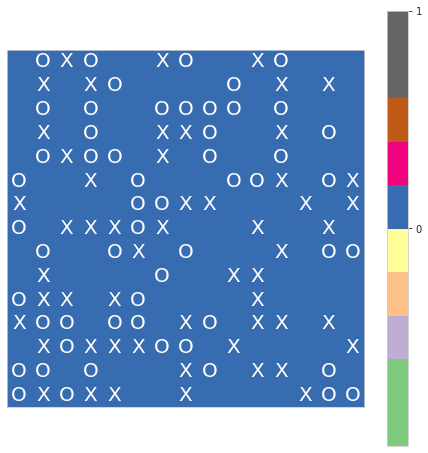

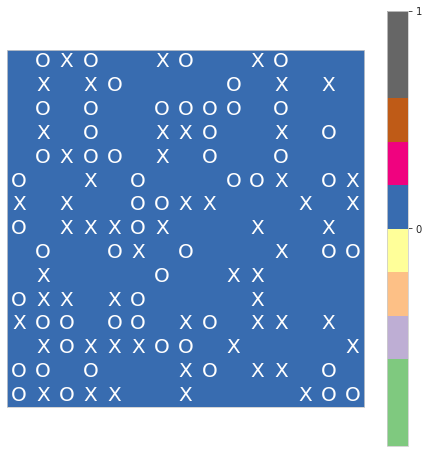

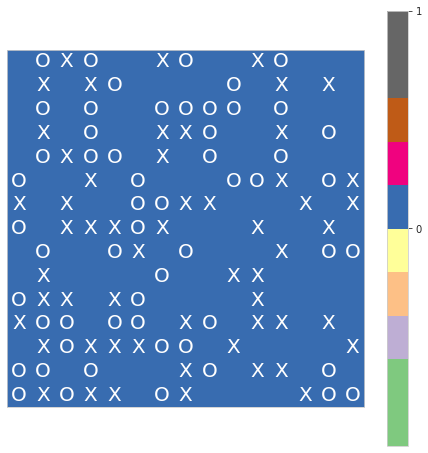

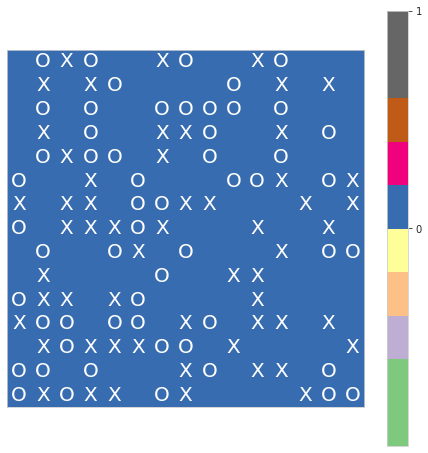

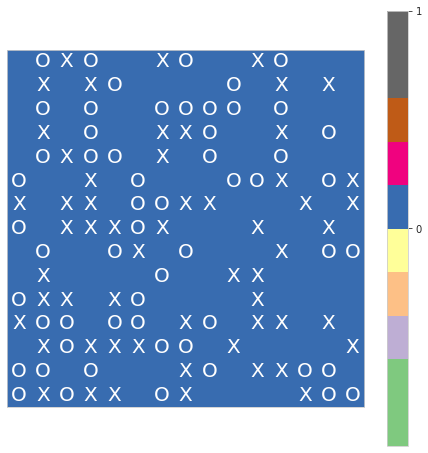

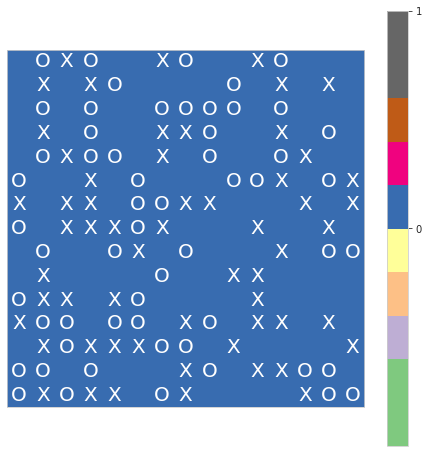

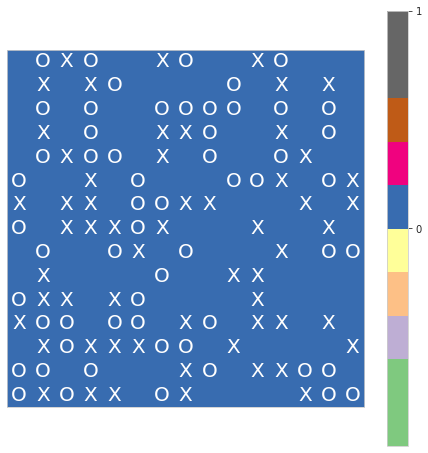

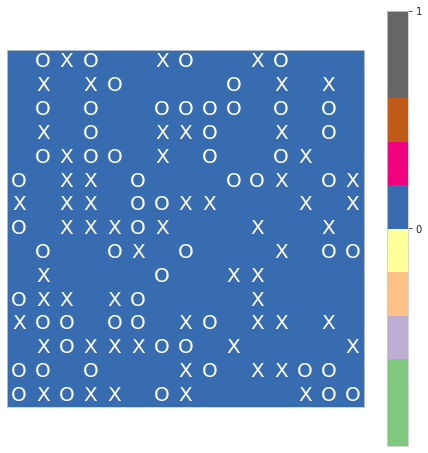

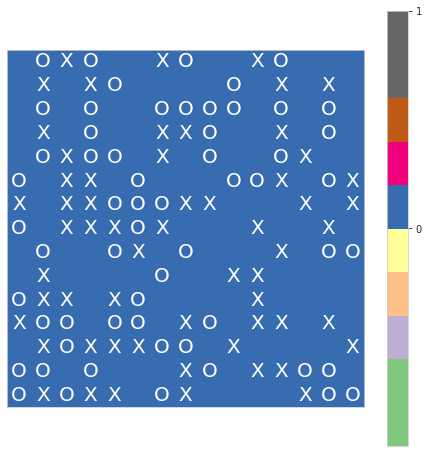

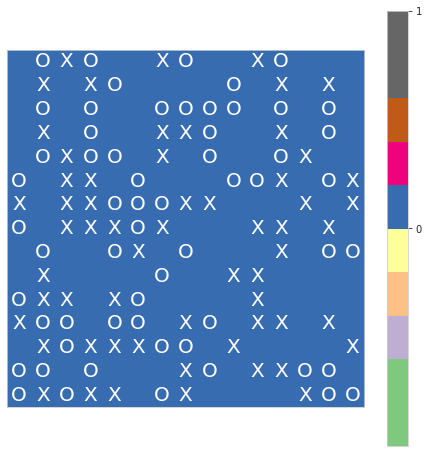

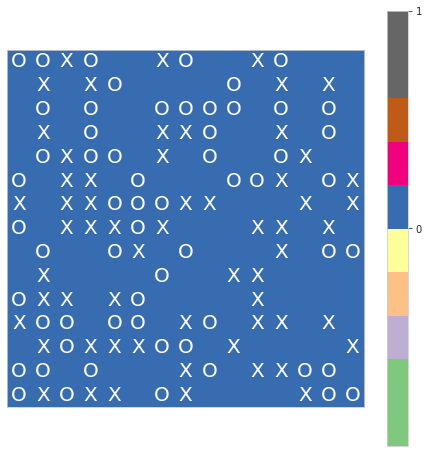

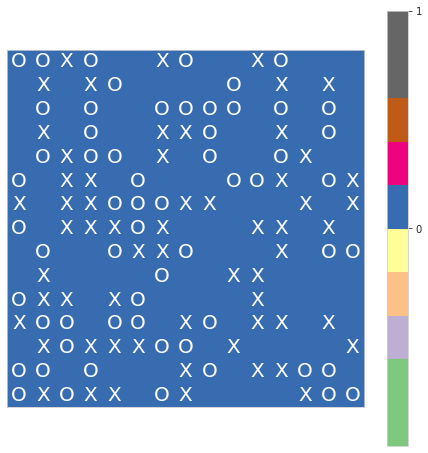

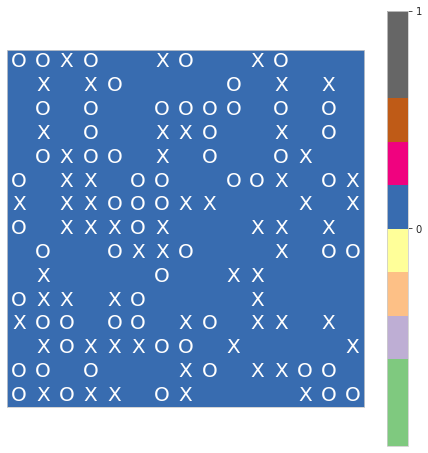

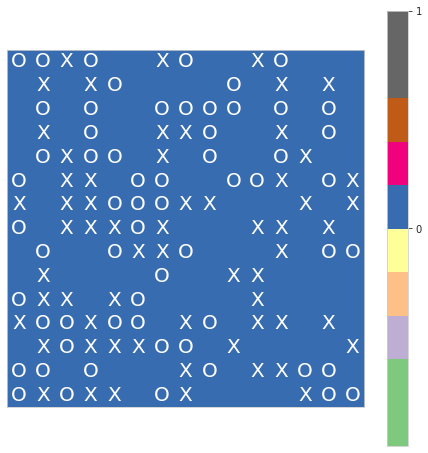

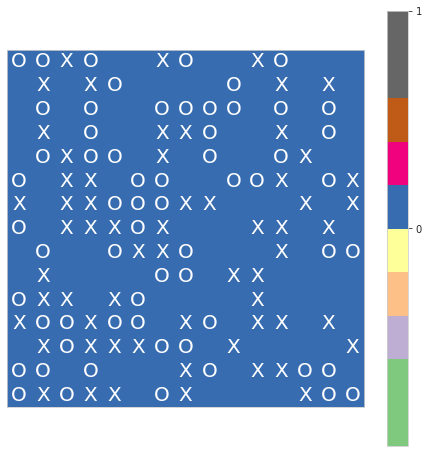

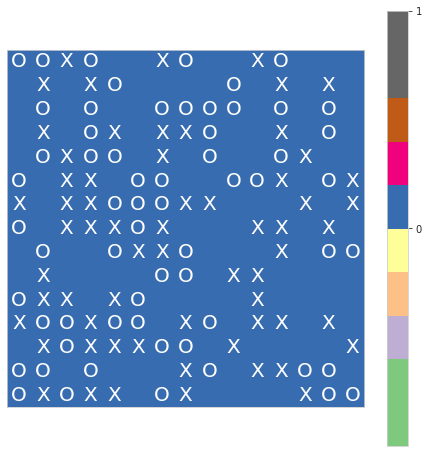

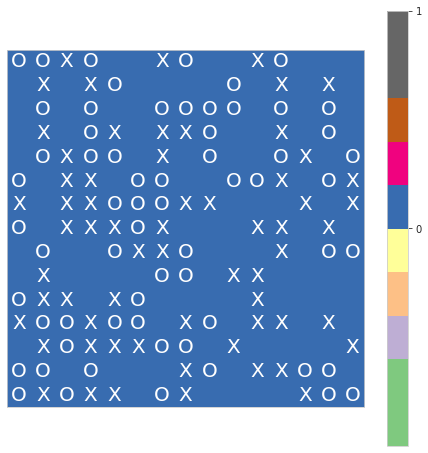

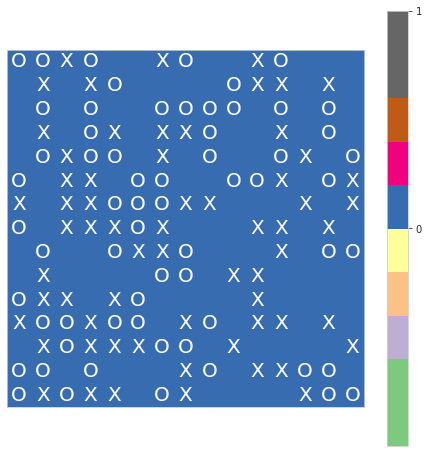

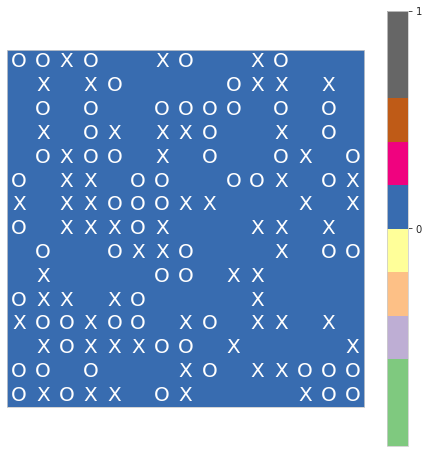

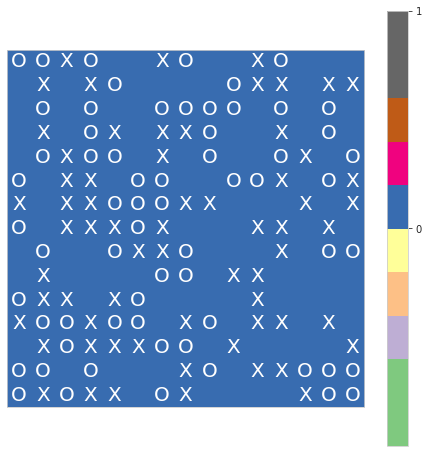

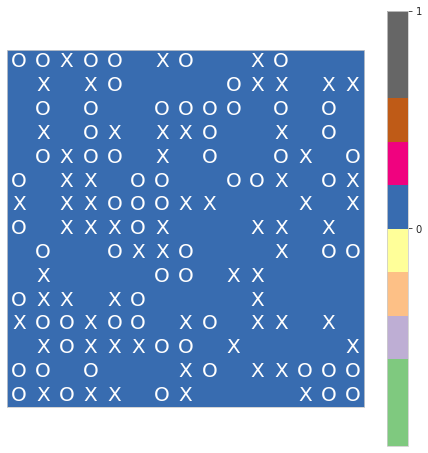

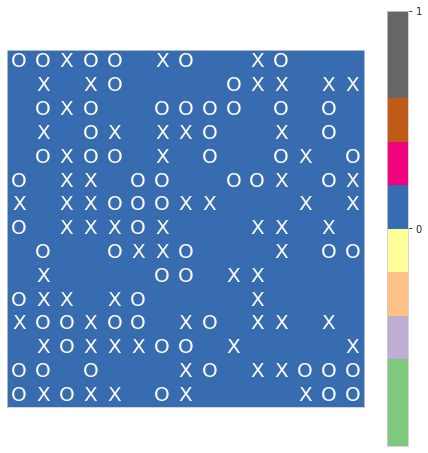

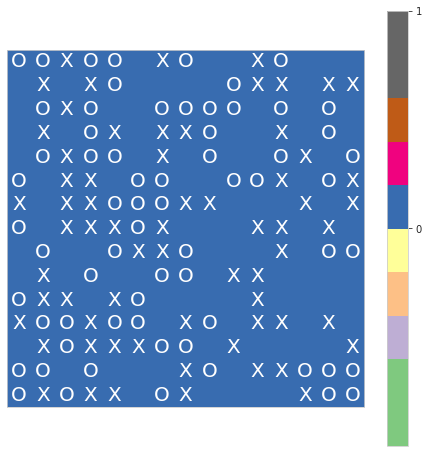

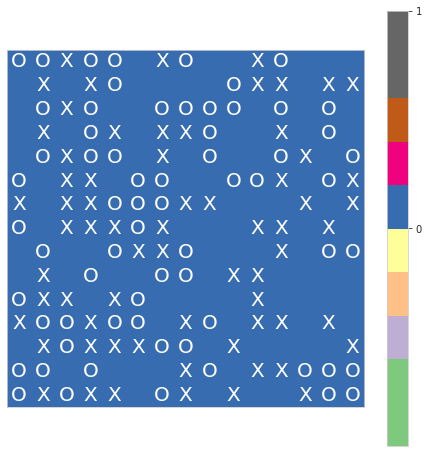

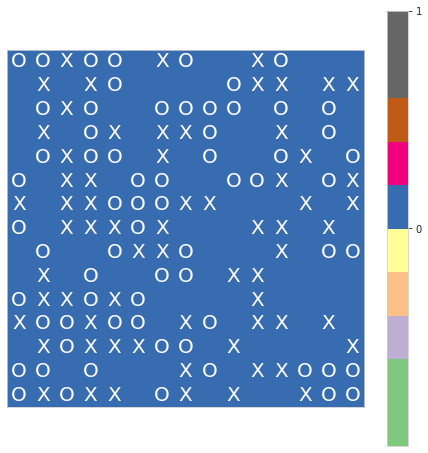

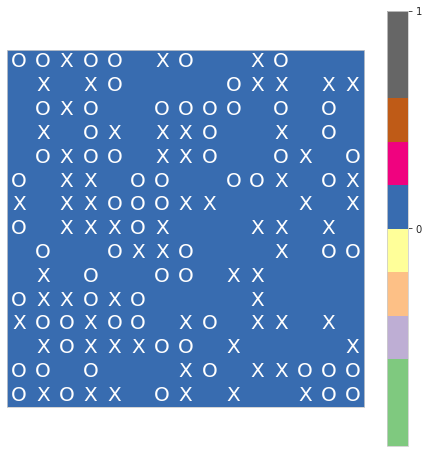

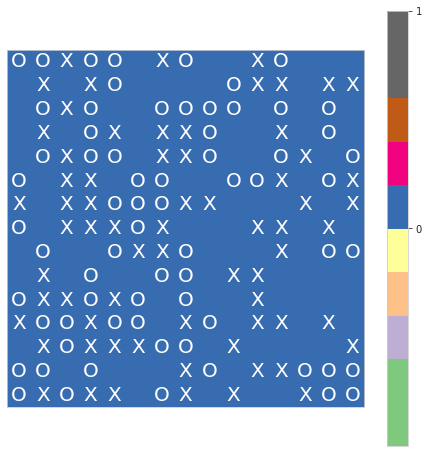

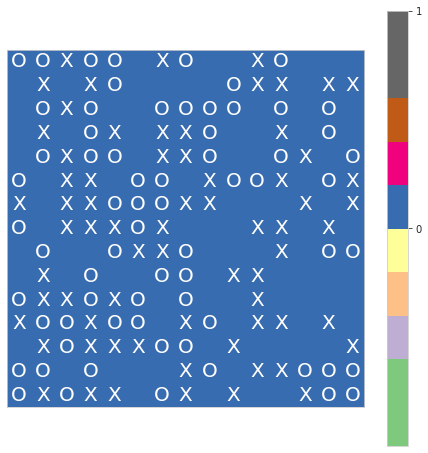

Нолики выиграли! reward=-1 done=True


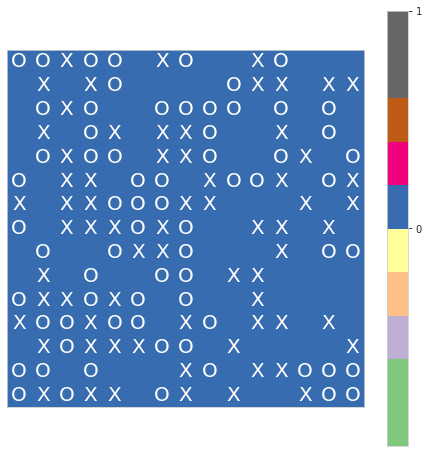

In [6]:
env = TicTacToe(n_rows=15, n_cols=15, n_win=5)
plot_test_game(env, None, None, random_crosses=True, random_naughts=True, verbose=True, fontx=20)

# Часть первая: крестики-нолики при помощи Q-обучения

## 1.
Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

Алгоритм: Sarsamax (Q-Learning)

![title](Q_learning.png)

Чтобы я мог следить за эволюцией обученных стратегий, я буду сравнивать их со случайной стратегией.

In [76]:
def play_game(env, pi1, pi2):
    """Играем тестовую партию между стратегиями или со случайными ходами"""
    done = False
    env.reset()
    pi1_actions = [0, 0]
    pi2_actions = [0, 0]
    while not done:
        state, actions = (env.getHash(), env.curTurn), env.getEmptySpaces()
        action = None
        if state[1] == 1:
            pi1_actions[0] += 1
            if pi1 is not None:
                action = pi1[state]
                if action is not None:
                    pi1_actions[1] += 1
        else:
            pi2_actions[0] += 1
            if pi2 is not None:
                action = pi2[state]
                if action is not None:
                    pi2_actions[1] += 1
        if action is None:
            action = actions[np.random.randint(len(actions))]
        observation, reward, done, info = env.step(action)
    return reward, pi1_actions, pi2_actions

In [77]:
def take_action_by_epsilon_greedy_pi(Q, state, actions, epsilon):
    """
    Для крестиков выбираем максимум, а для ноликов - минимум
    """
    if state in Q:
        indeces = np.ravel_multi_index((actions[:, 0], actions[:, 1]), dims=(env.n_rows, env.n_cols))
        Q_values = np.take(Q[state], indeces)
        epsilon_greedy_pi = np.ones(len(actions)) * epsilon / len(actions)
        curTurn = state[1]
        if curTurn == 1:
            best_a = np.argmax(Q_values)
        else:
            best_a = np.argmin(Q_values)
        epsilon_greedy_pi[best_a] = 1 - epsilon + (epsilon / len(actions))
    else:
        epsilon_greedy_pi = np.ones(len(actions)) / len(actions)  # равномерное распределение
    action_index = np.random.choice(np.arange(len(actions)), p=epsilon_greedy_pi)
    return tuple(actions[action_index])

In [78]:
def Q_learning_episode(env, Q, alpha, gamma, epsilon, curTurn):
    """
    Игру начинают крестики (env.curTurn == 1), а потом делаю ход нолики (env.curTurn == -1)
    """
    done = False
    env.reset()
    while not done:
        state, actions = (env.getHash(), env.curTurn), env.getEmptySpaces()
        if state[1] != curTurn:
            # делаем ход за противника по стратегии из Q
            action_ = take_action_by_epsilon_greedy_pi(Q, state, actions, epsilon)
            _ = env.step(action_)
            continue
        # делаем ход за агента которого обучаем
        action = take_action_by_epsilon_greedy_pi(Q, state, actions, epsilon)
        observation, reward, done, info = env.step(action)
        observation_state = (observation[0], observation[2])
        available_actions = observation[1]
        # сразу же делаем ход за противника если это возможно
        if not done:
            action_ = take_action_by_epsilon_greedy_pi(Q, observation_state, available_actions, epsilon)
            observation, reward, done, info = env.step(action_)
            observation_state = (observation[0], observation[2])
            available_actions = observation[1]
        if done:
            Q[state][action] = reward
            continue
        # выбираем максимальный Q
        indeces = np.ravel_multi_index((available_actions[:, 0], available_actions[:, 1]), dims=(env.n_rows, env.n_cols))
        Q_values = np.take(Q[observation_state], indeces)
        if curTurn == 1:
            best_Q_observation = np.max(Q_values)
        else:
            best_Q_observation = np.min(Q_values)
        Q[state][action] = Q[state][action] + \
            alpha * (reward + gamma * best_Q_observation - Q[state][action])
    return reward

In [92]:
def Q_learninig(env, num_episodes=20000, alpha=0.1, gamma=0.9, init_Q=None, eps_start=1.0, eps_decay=0.99,
                eps_step=10, eps_min=0.005):
    assert 0.0 <= eps_start <= 1.0
    if init_Q is None:
        Q = defaultdict(lambda: np.zeros((env.n_rows, env.n_cols)))
    else:
        Q = init_Q
    epsilon = eps_start
    noughts = []
    crosses = []
    for episode in tqdm(range(1, num_episodes + 1)):
        if episode % eps_step == 0:
            epsilon *= eps_decay
            epsilon = max(epsilon, eps_min)
        # 100 эпизодов обучаем нолики а потом 100 эпизодов крестики
        curTurn = 2 * ((episode // 100) % 2) - 1
        reward = Q_learning_episode(env, Q, alpha, gamma, epsilon, curTurn)
        if curTurn == 1:
            crosses.append(reward)
        else:
            noughts.append(reward)
        if episode % (num_episodes // 10) == 0:
            print(f"Эпизод[{episode}] epsilon={epsilon}")
            policy = defaultdict(lambda: None, 
                         dict((k, 
                               np.unravel_index(np.argmax(v) if k[1] == 1 else np.argmin(v),
                                                (env.n_rows, env.n_cols))
                              ) for k, v in Q.items()))
            games = np.array([play_game(env, policy, None) for _ in range(200)])
            rewards, pi1_actions, _ = map(list, zip(*games))
            rewards = np.array(rewards, dtype=int)
            sum_actions = np.sum(pi1_actions, axis=0)
            print(f"Эпизод[{episode}] Агент играя за крестики выигрывает {int(np.sum(rewards == 1))} игр из 200 сыгранных игр против случайной стратегии \n \
            при этом он не знает что делать в {(sum_actions[0] - sum_actions[1]) / sum_actions[0]} процентах случаев")
            games = np.array([play_game(env, None, policy) for _ in range(200)])
            rewards, _, pi2_actions = map(list, zip(*games))
            rewards = np.array(rewards, dtype=int)
            sum_actions = np.sum(pi2_actions, axis=0)
            print(f"Эпизод[{episode}] Агент играя за нолики выигрывает {int(np.sum(rewards == -1))} игр из 200 сыгранных игр против случайной стратегии \n \
            при этом он не знает что делать в {(sum_actions[0] - sum_actions[1]) / sum_actions[0]} процентах случаев")
    # в состояниях где агент не был - возвращаем None и будем обрабатывать отдельно, когда будем играть
    policy = defaultdict(lambda: None, 
                         dict((k, 
                               np.unravel_index(np.argmax(v) if k[1] == 1 else np.argmin(v),
                                                (env.n_rows, env.n_cols))
                              ) for k, v in Q.items()))
    noughts = np.array(noughts)
    crosses = np.array(crosses)
    games = [('0', noughts), ('X', crosses)]
    for game in games:
        y = np.convolve(np.array(game[1] == (-1 if game[0] == '0' else 1), dtype=int), np.ones(5000)/5000, mode='valid')
        print(y.shape)
        plt.scatter(np.arange(y.shape[0]), y)
        y = np.convolve(np.array(game[1] == 0, dtype=int), np.ones(5000)/5000, mode='valid')
        plt.scatter(np.arange(y.shape[0]), y)
    plt.legend(['0 Win', '0 Draw', 'X Win', 'X Draw'], loc='upper left')
    plt.title("Q-learning agent versus Q-learning agent")
    plt.show()
    return policy, Q, noughts, crosses

Эпизод[100000] epsilon=0.13530821527775866
Эпизод[100000] Агент играя за крестики выигрывает 196 игр из 200 сыгранных игр против случайной стратегии 
             при этом он не знает что делать в 0.0 процентах случаев
Эпизод[100000] Агент играя за нолики выигрывает 150 игр из 200 сыгранных игр против случайной стратегии 
             при этом он не знает что делать в 0.0 процентах случаев
Эпизод[200000] epsilon=0.05
Эпизод[200000] Агент играя за крестики выигрывает 196 игр из 200 сыгранных игр против случайной стратегии 
             при этом он не знает что делать в 0.0 процентах случаев
Эпизод[200000] Агент играя за нолики выигрывает 171 игр из 200 сыгранных игр против случайной стратегии 
             при этом он не знает что делать в 0.0 процентах случаев
Эпизод[300000] epsilon=0.05
Эпизод[300000] Агент играя за крестики выигрывает 200 игр из 200 сыгранных игр против случайной стратегии 
             при этом он не знает что делать в 0.0 процентах случаев
Эпизод[300000] Агент игра

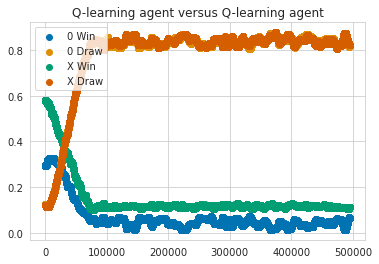

In [100]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
policy, Q, noughts, crosses = Q_learninig(env, num_episodes=1000000, alpha=0.005, gamma=1.0, init_Q=None, eps_start=1.0, eps_decay=0.9998,
                eps_step=10, eps_min=0.05)

Еще раз посмотрим как крестики играют против случайной стратегии и как нолики играют против случайной стратегии

In [101]:
games = np.array([play_game(env, policy, None) for _ in range(10000)])
rewards, pi1_actions, _ = map(list, zip(*games))
rewards = np.array(rewards, dtype=int)
sum_actions = np.sum(pi1_actions, axis=0)
print(f"Агент играя за крестики выигрывает {int(np.sum(rewards == 1))} игр, проигрывает {int(np.sum(rewards == -1))} из 10000 сыгранных игр против случайной стратегии \n \
при этом он не знает что делать в {(sum_actions[0] - sum_actions[1]) / sum_actions[0]} процентах случаев")

games = np.array([play_game(env, None, policy) for _ in range(10000)])
rewards, _, pi2_actions = map(list, zip(*games))
rewards = np.array(rewards, dtype=int)
sum_actions = np.sum(pi2_actions, axis=0)
print(f"Агент играя за нолики выигрывает {int(np.sum(rewards == -1))} игр, проигрывает {int(np.sum(rewards == 1))}  из 10000 сыгранных игр против случайной стратегии \n \
при этом он не знает что делать в {(sum_actions[0] - sum_actions[1]) / sum_actions[0]} процентах случаев")

Агент играя за крестики выигрывает 9883 игр, проигрывает 0 из 10000 сыгранных игр против случайной стратегии 
 при этом он не знает что делать в 0.0 процентах случаев
Агент играя за нолики выигрывает 8940 игр, проигрывает 0  из 10000 сыгранных игр против случайной стратегии 
 при этом он не знает что делать в 0.0 процентах случаев


## 2.
Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

Эпизод[100000] epsilon=0.9355129099573348
Эпизод[100000] Агент играя за крестики выигрывает 166 игр из 200 сыгранных игр против случайной стратегии 
             при этом он не знает что делать в 0.11271676300578035 процентах случаев
Эпизод[100000] Агент играя за нолики выигрывает 85 игр из 200 сыгранных игр против случайной стратегии 
             при этом он не знает что делать в 0.24759284731774414 процентах случаев
Эпизод[200000] epsilon=0.8751756528528015
Эпизод[200000] Агент играя за крестики выигрывает 189 игр из 200 сыгранных игр против случайной стратегии 
             при этом он не знает что делать в 0.01746031746031746 процентах случаев
Эпизод[200000] Агент играя за нолики выигрывает 101 игр из 200 сыгранных игр против случайной стратегии 
             при этом он не знает что делать в 0.141399416909621 процентах случаев
Эпизод[300000] epsilon=0.8187299343429234
Эпизод[300000] Агент играя за крестики выигрывает 199 игр из 200 сыгранных игр против случайной стратегии 
      

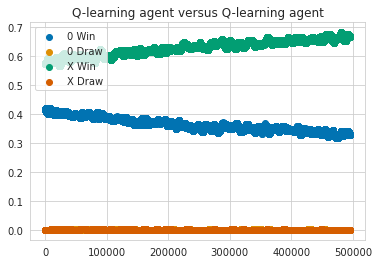

In [104]:
env = TicTacToe(n_rows=4, n_cols=4, n_win=3)
policy, Q, noughts, crosses = Q_learninig(env, num_episodes=1000000, alpha=0.005, gamma=1.0, init_Q=None, eps_start=1.0, eps_decay=0.99999,
                eps_step=15, eps_min=0.05)

Еще раз посмотрим как крестики играют против случайной стратегии и как нолики играют против случайной стратегии

In [105]:
games = np.array([play_game(env, policy, None) for _ in range(10000)])
rewards, pi1_actions, _ = map(list, zip(*games))
rewards = np.array(rewards, dtype=int)
sum_actions = np.sum(pi1_actions, axis=0)
print(f"Агент играя за крестики выигрывает {int(np.sum(rewards == 1))} игр, проигрывает {int(np.sum(rewards == -1))} из 10000 сыгранных игр против случайной стратегии \n \
при этом он не знает что делать в {(sum_actions[0] - sum_actions[1]) / sum_actions[0]} процентах случаев")

games = np.array([play_game(env, None, policy) for _ in range(10000)])
rewards, _, pi2_actions = map(list, zip(*games))
rewards = np.array(rewards, dtype=int)
sum_actions = np.sum(pi2_actions, axis=0)
print(f"Агент играя за нолики выигрывает {int(np.sum(rewards == -1))} игр, проигрывает {int(np.sum(rewards == 1))}  из 10000 сыгранных игр против случайной стратегии \n \
при этом он не знает что делать в {(sum_actions[0] - sum_actions[1]) / sum_actions[0]} процентах случаев")

Агент играя за крестики выигрывает 10000 игр, проигрывает 0 из 10000 сыгранных игр против случайной стратегии 
 при этом он не знает что делать в 0.0 процентах случаев
Агент играя за нолики выигрывает 5455 игр, проигрывает 358  из 10000 сыгранных игр против случайной стратегии 
 при этом он не знает что делать в 0.039888372093023254 процентах случаев


Эпизод[100000] epsilon=0.8187446718157355
Эпизод[100000] Агент играя за крестики выигрывает 110 игр из 200 сыгранных игр против случайной стратегии 
             при этом он не знает что делать в 0.45161290322580644 процентах случаев
Эпизод[100000] Агент играя за нолики выигрывает 45 игр из 200 сыгранных игр против случайной стратегии 
             при этом он не знает что делать в 0.44528301886792454 процентах случаев
Эпизод[200000] epsilon=0.6703227273415248
Эпизод[200000] Агент играя за крестики выигрывает 128 игр из 200 сыгранных игр против случайной стратегии 
             при этом он не знает что делать в 0.31952017448200654 процентах случаев
Эпизод[200000] Агент играя за нолики выигрывает 40 игр из 200 сыгранных игр против случайной стратегии 
             при этом он не знает что делать в 0.3555858310626703 процентах случаев
Эпизод[300000] epsilon=0.5488066967130222
Эпизод[300000] Агент играя за крестики выигрывает 159 игр из 200 сыгранных игр против случайной стратегии 
      

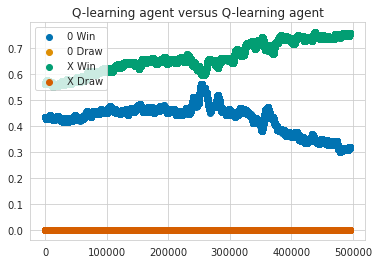

In [106]:
env = TicTacToe(n_rows=5, n_cols=5, n_win=3)
policy, Q, noughts, crosses = Q_learninig(env, num_episodes=1000000, alpha=0.005, gamma=1.0, init_Q=None, eps_start=1.0, eps_decay=0.99997,
                eps_step=15, eps_min=0.05)

Еще раз посмотрим как крестики играют против случайной стратегии и как нолики играют против случайной стратегии

In [108]:
games = np.array([play_game(env, policy, None) for _ in range(10000)])
rewards, pi1_actions, _ = map(list, zip(*games))
rewards = np.array(rewards, dtype=int)
sum_actions = np.sum(pi1_actions, axis=0)
print(f"Агент играя за крестики выигрывает {int(np.sum(rewards == 1))} игр, проигрывает {int(np.sum(rewards == -1))} из 10000 сыгранных игр против случайной стратегии \n \
при этом он не знает что делать в {(sum_actions[0] - sum_actions[1]) / sum_actions[0]} процентах случаев")

games = np.array([play_game(env, None, policy) for _ in range(10000)])
rewards, _, pi2_actions = map(list, zip(*games))
rewards = np.array(rewards, dtype=int)
sum_actions = np.sum(pi2_actions, axis=0)
print(f"Агент играя за нолики выигрывает {int(np.sum(rewards == -1))} игр, проигрывает {int(np.sum(rewards == 1))}  из 10000 сыгранных игр против случайной стратегии \n \
при этом он не знает что делать в {(sum_actions[0] - sum_actions[1]) / sum_actions[0]} процентах случаев")

Агент играя за крестики выигрывает 9595 игр, проигрывает 150 из 10000 сыгранных игр против случайной стратегии 
 при этом он не знает что делать в 0.026939243408482996 процентах случаев
Агент играя за нолики выигрывает 3184 игр, проигрывает 2211  из 10000 сыгранных игр против случайной стратегии 
 при этом он не знает что делать в 0.3334276600123482 процентах случаев


# Часть вторая: добавим нейронных сетей

Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).


## 3.
Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.

Мой текущий код стратегий не расширяется, поэтому перепишу его.

In [21]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [22]:
class DQNNetwork(nn.Module):
    def __init__(self, hidden_channels=15):
        nn.Module.__init__(self)
        self.l1 = nn.Conv2d(in_channels=1, out_channels=hidden_channels, kernel_size=3, padding=1)
        self.l2 = nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=3, padding=1)
        self.l3 = nn.Conv2d(in_channels=hidden_channels, out_channels=1, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.tanh(self.l1(x))
        x = F.tanh(self.l2(x))
        x = self.l3(x)
        return x

In [23]:
class model_dict(collections.UserDict):
    def __init__(self, model=None, converter=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.model = model
        self.converter = converter

    def __missing__(self, key):
        if self.model is None:
            raise KeyError(key)
        if key not in self:
            self[key] = self.model(self.converter(key))[0, 0].detach().numpy()
        return self[key]
        
class DQNTicTacAgent():
    def __init__(self, learning_rate=1e-3, n_rows=3, n_cols=3):
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.model = DQNNetwork(hidden_channels=15).to(self.device)
        self.crosses_memory = ReplayMemory(1000)
        self.noughts_memory = ReplayMemory(1000)
        self.optimizer = optim.Adam(self.model.parameters(), learning_rate, weight_decay=1e-5)
        self.steps_done = [0, 0]
        
        self.trainable = True
        self.gamma = 1.0
        self.batch_size = 64
        
        self.eps, self.eps_final, self.eps_step, self.eps_decay = [1.0, 1.0], 0.05, 100, 0.995
        self.sessions = []
        self.n_rows = n_rows
        self.n_cols = n_cols
        
    def getSideFromState(self, state):
        steps = 0
        for c in state:
            if c == '2' or c == '1':
                steps += 1
        side = -2 * (steps % 2) + 1
        return side
        
    def getActionGreedy(self, state, actions):
        """
        Возвращем индекс лучшего действия
        """
        side = self.getSideFromState(state)
        state = self.convertState(state)
        Q_state = self.model(state)[0, 0].detach().numpy()
        indeces = np.ravel_multi_index((actions[:, 0], actions[:, 1]), dims=(self.n_rows, self.n_cols))
        Q_values = np.take(Q_state, indeces)
        if side == 1:
            action_index = np.argmax(Q_values)
        else:
            action_index = np.argmin(Q_values)
        return actions[action_index]
    
    @property
    def Q(self):
        """
        Возвращаем Q таблицу
        """
        return model_dict(self.model, self.convertState)
    
    def getAction(self, state, actions, side):
        """
        Возвращает позицию на которую нужно поставить крестик/нолик.
        Действие выбираем с учетом эпсилон.
        """
        Q_state = self.model(state)[0, 0].detach().numpy()
        # ищем индекс где
        indeces = np.ravel_multi_index((actions[:, 0], actions[:, 1]), dims=(self.n_rows, self.n_cols))
        Q_values = np.take(Q_state, indeces)
        epsilon_greedy_pi = np.ones(len(actions)) * self.eps[(side + 1) // 2] / len(actions)
        if side == 1:
            best_a = np.argmax(Q_values)
        else:
            best_a = np.argmin(Q_values)
        epsilon_greedy_pi[best_a] = 1 - self.eps[(side + 1) // 2] + (self.eps[(side + 1) // 2] / len(actions))
        action_index = np.random.choice(np.arange(len(actions)), p=epsilon_greedy_pi)
        return actions[action_index]
        
    def convertState(self, state):
        convertedState = torch.tensor(list(map(int, list(state))), dtype=torch.float32).reshape(self.n_rows, self.n_cols)
        return convertedState[None, None, :, :] - 1
    
    def checkSessionHistory(self, session_id):
        if len(self.sessions[session_id][1]) == 2:
            # если в истории сесии есть два события, то добавим их в память
            state, action, _ = self.sessions[session_id][1][0]
            self.sessions[session_id][1] = self.sessions[session_id][1][1:]
            next_state, _, reward = self.sessions[session_id][1][0]
            if self.sessions[session_id][0] == 1:
                memory = self.crosses_memory
            else:
                memory = self.noughts_memory
            action = self.n_rows * action[0] + action[1]
            action = torch.tensor([action])[None, :]
            reward = torch.tensor([reward])[None, :]
            memory.push(state, action, 
                        next_state, reward)
    
    def move(self, env, session_id):
        state, actions = env.getHash(), env.getEmptySpaces()
        state = self.convertState(state)
        action = self.getAction(state, actions, self.sessions[session_id][0])
        _, reward, done, _ = env.step(action)
        # добавляем новую тройку в историю сесии
        self.sessions[session_id][1].append((state, action, reward))
        self.checkSessionHistory(session_id)
        if self.trainable:
            self.learn(self.sessions[session_id][0])
        return reward, done
    
    def learn(self, side):
        if side == 1:
            memory = self.crosses_memory
        else:
            memory = self.noughts_memory
        if len(memory) < 4 * self.batch_size:
            return
        # берём мини-батч из памяти
        transitions = memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)
        batch_state = Variable(torch.cat(batch_state)).to(self.device)
        batch_action = Variable(torch.cat(batch_action)).to(self.device)
        batch_reward = Variable(torch.cat(batch_reward)).to(self.device)
        batch_next_state = Variable(torch.cat(batch_next_state)).to(self.device)
        # считаем значения функции Q
        Q = self.model(batch_state).view(self.batch_size, -1).gather(1, batch_action).reshape([self.batch_size])
        # оцениваем ожидаемые значения после этого действия
        Qmax = self.model(batch_next_state).detach()
        Qmax[batch_next_state != 0] = 0
        if side == 1:
            Qmax = Qmax.view(self.batch_size, -1).max(1)[0]
        else:
            Qmax = Qmax.view(self.batch_size, -1).min(1)[0]
        Qnext = batch_reward.reshape([self.batch_size]) + (self.gamma * Qmax)
        Qnext[batch_reward.view(-1) == 1] = 1
        Qnext[batch_reward.view(-1) == -1] = -1
        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.mse_loss(Q, Qnext)  # F.smooth_l1_loss(Q, Qnext)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
    def newGame(self, side):
        self.steps_done[(side + 1) // 2] += 1
        if self.steps_done[(side + 1) // 2] % self.eps_step == 0:
            self.eps[(side + 1) // 2] *= self.eps_decay
            self.eps[(side + 1) // 2] = max(self.eps[(side + 1) // 2], self.eps_final)
        session_id = len(self.sessions)
        self.sessions.append([side, []])
        return session_id
    
    def endGame(self, env, result, session_id):
        state = env.getHash()
        state = self.convertState(state)
        # добавить новое состояние в сессию
        self.sessions[session_id][1].append((state, None, result))
        # сформировать новую пару ('state', 'action', 'next_state', 'reward') и добавить ее в replay
        self.checkSessionHistory(session_id)
        # обучиться если можно
        if self.trainable:
            self.learn(self.sessions[session_id][0])
        # удалить сессию
        self.sessions.pop(session_id)

In [24]:
class RandomAgent():
    def __init__(self, n_rows=3, n_cols=3):
        self.n_rows = n_rows
        self.n_cols = n_cols
        
    def getActionGreedy(self, state, actions):
        """
        Возвращем индекс лучшего действия
        """
        index = np.random.randint(len(actions))
        return actions[index]
    
    @property
    def Q(self):
        """
        Возвращаем Q таблицу
        """
        return defaultdict(lambda: np.zeros((self.n_rows, self.n_cols)))
        
    
    def move(self, env, session_id):
        pass
    
    def newGame(self, side):
        return 0
    
    def endGame(self, env, result, session_id):
        pass

In [25]:
def play_game(env, player1, player2, training=True):
    if player1 is None:
        player1 = RandomAgent(env.n_rows, env.n_cols)
    if player2 is None:
        player2 = RandomAgent(env.n_rows, env.n_cols)
    if training:
        player1_session_id = player1.newGame(1)
        player2_session_id = player2.newGame(-1)
        env.reset()

        finished = False
        while not finished:
            result, finished = player1.move(env, player1_session_id)
            if not finished:
                result, finished = player2.move(env, player2_session_id)

        # сначала завершаем игру за второго игрока (косяк реализации сессий)
        player2.endGame(env, result, player2_session_id)
        player1.endGame(env, result, player1_session_id)
    else:
        env.reset()
        finished = False
        while not finished:
            state, actions, curTurn = env.getHash(), env.getEmptySpaces(), env.curTurn
            if curTurn == 1:
                action = player1.getActionGreedy(state, actions)
            else:
                action = player2.getActionGreedy(state, actions)
            _, result, finished, _ = env.step(action)
    return result


def battle(env, player1, player2, n_games=100000, title="DQN agent versus DQN agent"):
    n_dots = min(10000, n_games)
    window_size = 1000
    step_size = n_games // n_dots
    results = []
    for i in tqdm(range(n_games)):
        result = play_game(env, player1, player2)
        if i % step_size == 0:
            results.append(result)
        if i % (n_games // 10) == 0:
            print("Эписолн для крестиков и ноликов ", player1.eps[1], " ", player2.eps[0])
            crosses_rewards = np.array([play_game(env, player1, None, training=False) for i in range(200)])
            print(f"""Эпизод[{i}] Крестики против рандома 200 игр: выигрышей = {int(np.sum(crosses_rewards == 1))}, 
            ничьих = {int(np.sum(crosses_rewards == 0))}""")
            noughts_rewards = np.array([play_game(env, None, player2, training=False) for i in range(200)])
            print(f"""Эпизод[{i}] Нолики против рандома 200 игр: выигрышей = {int(np.sum(noughts_rewards == -1))}, 
            ничьих = {int(np.sum(noughts_rewards == 0))}""")
         
    results = np.array(results, dtype=int)
    results_ = [('0 win', np.array(results == -1, dtype=int)), ('X win', np.array(results == 1, dtype=int)), 
             ('Draw', np.array(results == 0, dtype=int))]
    for result in results_:
        y = np.convolve(result[1], np.ones(window_size) / window_size, mode='valid')
        plt.scatter(np.arange(y.shape[0]), y)
    plt.legend([result[0] for result in results_], loc='upper left')
    plt.title(title)
    plt.show()
    return results

Эписолн для крестиков и ноликов  1.0   1.0
Эпизод[0] Крестики против рандома 200 игр: выигрышей = 138, 
            ничьих = 10
Эпизод[0] Нолики против рандома 200 игр: выигрышей = 26, 
            ничьих = 48
Эписолн для крестиков и ноликов  0.3669578217261671   0.3669578217261671
Эпизод[20000] Крестики против рандома 200 игр: выигрышей = 119, 
            ничьих = 17
Эпизод[20000] Нолики против рандома 200 игр: выигрышей = 48, 
            ничьих = 32
Эписолн для крестиков и ноликов  0.1346580429260134   0.1346580429260134
Эпизод[40000] Крестики против рандома 200 игр: выигрышей = 130, 
            ничьих = 12
Эпизод[40000] Нолики против рандома 200 игр: выигрышей = 52, 
            ничьих = 18
Эписолн для крестиков и ноликов  0.05   0.05
Эпизод[60000] Крестики против рандома 200 игр: выигрышей = 155, 
            ничьих = 15
Эпизод[60000] Нолики против рандома 200 игр: выигрышей = 62, 
            ничьих = 21
Эписолн для крестиков и ноликов  0.05   0.05
Эпизод[80000] Крестики против

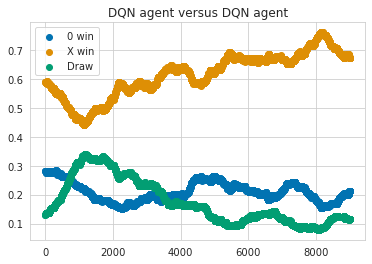

In [26]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
agent = DQNTicTacAgent(n_rows=3, n_cols=3, learning_rate=5e-4)
results = battle(env, agent, agent, n_games=200000, title="DQN agent versus DQN agent")

In [27]:
torch.save(agent.model, "./dqn_model.pth")

Эписолн для крестиков и ноликов  1.0   1.0
Эпизод[0] Крестики против рандома 200 игр: выигрышей = 142, 
            ничьих = 11
Эпизод[0] Нолики против рандома 200 игр: выигрышей = 57, 
            ничьих = 7
Эписолн для крестиков и ноликов  0.3669578217261671   0.3669578217261671
Эпизод[20000] Крестики против рандома 200 игр: выигрышей = 132, 
            ничьих = 30
Эпизод[20000] Нолики против рандома 200 игр: выигрышей = 61, 
            ничьих = 19
Эписолн для крестиков и ноликов  0.1346580429260134   0.1346580429260134
Эпизод[40000] Крестики против рандома 200 игр: выигрышей = 134, 
            ничьих = 23
Эпизод[40000] Нолики против рандома 200 игр: выигрышей = 45, 
            ничьих = 45
Эписолн для крестиков и ноликов  0.05   0.05
Эпизод[60000] Крестики против рандома 200 игр: выигрышей = 141, 
            ничьих = 31
Эпизод[60000] Нолики против рандома 200 игр: выигрышей = 41, 
            ничьих = 34
Эписолн для крестиков и ноликов  0.05   0.05
Эпизод[80000] Крестики против 

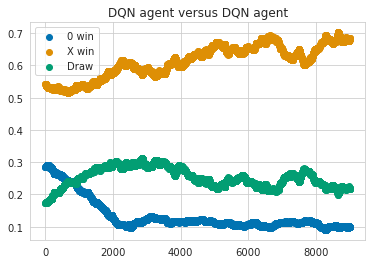

In [28]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
agent1 = DQNTicTacAgent(n_rows=3, n_cols=3, learning_rate=5e-4)
agent2 = DQNTicTacAgent(n_rows=3, n_cols=3, learning_rate=5e-4)
results_1 = battle(env, agent1, agent2, n_games=200000, title="DQN agent versus DQN agent")

In [29]:
torch.save(agent1.model, "./dqn_model_agent1_1.pth")
torch.save(agent2.model, "./dqn_model_agent2_1.pth")

### Вывод

Попробовал обучить DQN, но ничего не получилось. Менял архитектуру, подбирал learning rate, два дня пытался найти ошибку в коде, но ничего не помогло. Обучил отдельные сети для крестиков и ноликов, но и это не помогло.

In [127]:
class DDQNNetwork(nn.Module):
    """
    Dueling DQN Network
    """
    def __init__(self, hidden_channels=15):
        nn.Module.__init__(self)
        self.l1 = nn.Conv2d(in_channels=1, out_channels=hidden_channels, kernel_size=5, padding=2)
        self.l2 = nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=3, padding=1)
        self.advantage = nn.Conv2d(in_channels=hidden_channels, out_channels=1, kernel_size=3, padding=1)
        self.value = nn.Conv2d(in_channels=hidden_channels, out_channels=1, kernel_size=1, padding=0)

    def forward(self, x):
        x = F.relu(self.l1(x))
        feature = F.relu(self.l2(x))
        value = self.value(feature.mean(dim=(-2, -1), keepdim=True))
        advantage = self.advantage(feature)
        x = value + (advantage - advantage.mean(dim=(-2, -1), keepdim=True))
        return x
    
class DDDQNTicTacAgent():
    """
    Double dueling DQN
    """
    def __init__(self, learning_rate=1e-3, n_rows=3, n_cols=3):
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.model = DDQNNetwork(hidden_channels=3).to(self.device)
        self.target_model = DDQNNetwork(hidden_channels=3).to(self.device)
        self.crosses_memory = [ReplayMemory(1000), ReplayMemory(1000), ReplayMemory(1000)]
        self.noughts_memory = [ReplayMemory(1000), ReplayMemory(1000), ReplayMemory(1000)]
        self.optimizer = optim.Adam(self.model.parameters(), learning_rate, weight_decay=1e-6)
        self.steps_done = [0, 0]
        
        self.trainable = True
        self.gamma = 1.0
        self.batch_size = 64 * 3
        self.sync_target_steps = 1000 
        
        self.eps, self.eps_final, self.eps_step, self.eps_decay = [1.0, 1.0], 0.05, 100, 0.995
        self.sessions = []
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.cross_losses = []
        self.nought_losses = []
        
    def getSideFromState(self, state):
        steps = 0
        for c in state:
            if c == '2' or c == '1':
                steps += 1
        side = -2 * (steps % 2) + 1
        return side
        
    def getActionGreedy(self, state, actions):
        """
        Возвращем индекс лучшего действия
        """
        side = self.getSideFromState(state)
        state = self.convertState(state)
        Q_state = self.model(state)[0, 0].detach().numpy()
        indeces = np.ravel_multi_index((actions[:, 0], actions[:, 1]), dims=(self.n_rows, self.n_cols))
        Q_values = np.take(Q_state, indeces)
        if side == 1:
            action_index = np.argmax(Q_values)
        else:
            action_index = np.argmin(Q_values)
        return actions[action_index]
    
    @property
    def Q(self):
        """
        Возвращаем Q таблицу
        """
        return model_dict(self.model, self.convertState)
    
    def getAction(self, state, actions, side):
        """
        Возвращает позицию на которую нужно поставить крестик/нолик.
        Действие выбираем с учетом эпсилон.
        """
        Q_state = self.model(state)[0, 0].detach().numpy()
        # ищем индекс где
        indeces = np.ravel_multi_index((actions[:, 0], actions[:, 1]), dims=(self.n_rows, self.n_cols))
        Q_values = np.take(Q_state, indeces)
        epsilon_greedy_pi = np.ones(len(actions)) * self.eps[(side + 1) // 2] / len(actions)
        if side == 1:
            best_a = np.argmax(Q_values)
        else:
            best_a = np.argmin(Q_values)
        epsilon_greedy_pi[best_a] = 1 - self.eps[(side + 1) // 2] + (self.eps[(side + 1) // 2] / len(actions))
        action_index = np.random.choice(np.arange(len(actions)), p=epsilon_greedy_pi)
        return actions[action_index]
        
    def convertState(self, state):
        convertedState = torch.tensor(list(map(int, list(state))), dtype=torch.float32).reshape(self.n_rows, self.n_cols)
        return convertedState[None, None, :, :] - 1
    
    def checkSessionHistory(self, session_id):
        if len(self.sessions[session_id][1]) == 2:
            # если в истории сесии есть два события, то добавим их в память
            state, action, _ = self.sessions[session_id][1][0]
            self.sessions[session_id][1] = self.sessions[session_id][1][1:]
            next_state, _, reward = self.sessions[session_id][1][0]
            if self.sessions[session_id][0] == 1:
                memory = self.crosses_memory
            else:
                memory = self.noughts_memory
            action = np.ravel_multi_index((action[0], action[1]), dims=(self.n_rows, self.n_cols))
            action = torch.tensor([action])[None, :]
            reward = torch.tensor([reward])[None, :]
            memory[reward[0] + 1].push(state, action, 
                        next_state, reward)
    
    def move(self, env, session_id):
        state, actions = env.getHash(), env.getEmptySpaces()
        state = self.convertState(state)
        action = self.getAction(state, actions, self.sessions[session_id][0])
        _, reward, done, _ = env.step(action)
        # добавляем новую тройку в историю сесии
        self.sessions[session_id][1].append((state, action, reward))
        self.checkSessionHistory(session_id)
        if self.trainable:
            self.learn(self.sessions[session_id][0])
        return reward, done
    
    def learn(self, side):
        if side == 1:
            memory = self.crosses_memory
        else:
            memory = self.noughts_memory
        if (len(memory[0]) < 2 * self.batch_size) or (len(memory[1]) < 2 * self.batch_size) or \
                (len(memory[2]) < 2 * self.batch_size):
            return
        # берём мини-батч из памяти
        transitions = [memory[i].sample(self.batch_size // 3) for i in range(3)]
        transitions = [x for arr in transitions for x in arr]
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)
        batch_state = Variable(torch.cat(batch_state)).to(self.device)
        batch_action = Variable(torch.cat(batch_action)).to(self.device)
        batch_reward = Variable(torch.cat(batch_reward)).to(self.device)
        batch_next_state = Variable(torch.cat(batch_next_state)).to(self.device)
        # считаем значения функции Q
        Q = self.model(batch_state).view(self.batch_size, -1).gather(1, batch_action).reshape([self.batch_size])
        # оцениваем ожидаемые значения после этого действия
        Qmax = self.target_model(batch_next_state).detach()
        if side == 1:
            Qmax[batch_next_state != 0] = -1e6
            Qmax = Qmax.view(self.batch_size, -1).max(1)[0]
        else:
            Qmax[batch_next_state != 0] = 1e6
            Qmax = Qmax.view(self.batch_size, -1).min(1)[0]
        Qnext = batch_reward.reshape([self.batch_size]) + (self.gamma * Qmax)
        Qnext[batch_reward.view(-1) == 1] = 1
        Qnext[batch_reward.view(-1) == -1] = -1
        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
#         if np.random.rand() < 1e-4:
#             print("Q ", Q[:5])
#             print("Qnext ", Qnext[:5])
        loss = F.smooth_l1_loss(Q, Qnext)  # F.smooth_l1_loss(Q, Qnext) F.mse_loss(Q, Qnext)
        if side == 1:
            self.cross_losses.append(loss.item())
        else:
            self.nought_losses.append(loss.item())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
    def newGame(self, side):
        self.steps_done[(side + 1) // 2] += 1
        if self.steps_done[(side + 1) // 2] % self.eps_step == 0:
            self.eps[(side + 1) // 2] *= self.eps_decay
            self.eps[(side + 1) // 2] = max(self.eps[(side + 1) // 2], self.eps_final)
        if (self.steps_done[0] % self.sync_target_steps == 0) or \
                (self.steps_done[1] % self.sync_target_steps == 0):
            self.target_model.load_state_dict(self.model.state_dict())
        session_id = len(self.sessions)
        self.sessions.append([side, []])
        return session_id
    
    def endGame(self, env, result, session_id):
        # ToDo возможно ошибка в обработке терминального сотояния (ведь здесь мы засовываем в модель терминальнуо состояние)
        state = env.getHash()
        state = self.convertState(state)
        # добавить новое состояние в сессию
        self.sessions[session_id][1].append((state, None, result))
        # сформировать новую пару ('state', 'action', 'next_state', 'reward') и добавить ее в replay
        self.checkSessionHistory(session_id)
        # обучиться если можно
        if self.trainable:
            self.learn(self.sessions[session_id][0])
        # удалить сессию
        self.sessions.pop(session_id)

Эписолн для крестиков и ноликов  1.0   1.0
Эпизод[0] Крестики против рандома 200 игр: выигрышей = 117, 
            ничьих = 27
Эпизод[0] Нолики против рандома 200 игр: выигрышей = 43, 
            ничьих = 42
Эписолн для крестиков и ноликов  0.8603841919146962   0.8603841919146962
Эпизод[3000] Крестики против рандома 200 игр: выигрышей = 145, 
            ничьих = 21
Эпизод[3000] Нолики против рандома 200 игр: выигрышей = 38, 
            ничьих = 16
Эписолн для крестиков и ноликов  0.7402609576967045   0.7402609576967045
Эпизод[6000] Крестики против рандома 200 игр: выигрышей = 88, 
            ничьих = 42
Эпизод[6000] Нолики против рандома 200 игр: выигрышей = 31, 
            ничьих = 26
Эписолн для крестиков и ноликов  0.6369088258938781   0.6369088258938781
Эпизод[9000] Крестики против рандома 200 игр: выигрышей = 132, 
            ничьих = 25
Эпизод[9000] Нолики против рандома 200 игр: выигрышей = 27, 
            ничьих = 37
Эписолн для крестиков и ноликов  0.547986285490042   

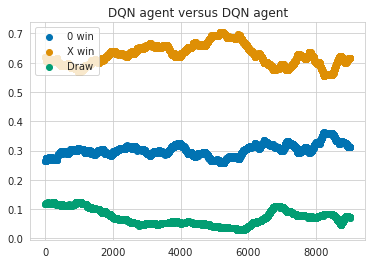

In [128]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
d_agent1 = DDDQNTicTacAgent(n_rows=3, n_cols=3, learning_rate=1e-5)
d_agent2 = DDDQNTicTacAgent(n_rows=3, n_cols=3, learning_rate=1e-5)
results_2 = battle(env, d_agent1, d_agent2, n_games=30000, title="DQN agent versus DQN agent")

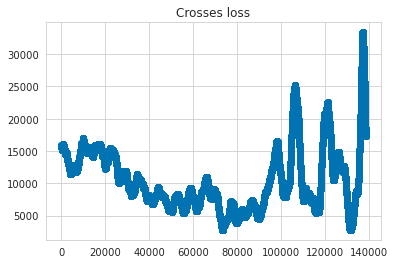

In [129]:
window_size = 1000
y = np.convolve(np.array(d_agent1.cross_losses), np.ones(window_size) / window_size, mode='valid')
plt.scatter(np.arange(y.shape[0]), y)
plt.title("Crosses loss")
plt.show()

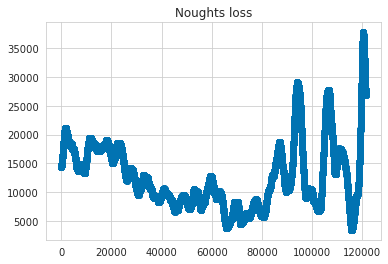

In [130]:
window_size = 1000
y = np.convolve(np.array(d_agent2.nought_losses), np.ones(window_size) / window_size, mode='valid')
plt.scatter(np.arange(y.shape[0]), y)
plt.title("Noughts loss")
plt.show()

In [131]:
torch.save(d_agent1.model, "./dqn_model_d_agent1_1.pth")
torch.save(d_agent2.model, "./dqn_model_d_agent2_1.pth")

# Вывод

Менял функции активации, подбирал количество слоев, сделал равномерное обучение на выигрышах, проигрышах и ничьих, добавил регуляризацию. Но ничего не помогло.